# Carga de datos

In [1]:
# Instalar dependencias necesarias (solo la primera vez)
!pip install rpy2
!pip install pyreadr # Install the pyreadr package, it is a modern and better alternative to rdata.
!pip install rdata # Install rdata to resolve the ModuleNotFoundError
!pip install xgboost
%pip install tensorflow
!pip install streamlit

import os
import urllib.request
import rdata
import pandas as pd

# Nombre del archivo a usar
file_name = "Madrid_Sale.rda"
file_url = f"https://github.com/paezha/idealista18/raw/master/data/{file_name}"
file_path = os.path.join("data", file_name)

# Crear carpeta 'data' si no existe
os.makedirs("data", exist_ok=True)

# Descargar el archivo si no existe
if not os.path.isfile(file_path):
    print("Descargando archivo...")
    urllib.request.urlretrieve(file_url, file_path)
else:
    print("Archivo ya existe.")

# Leer el archivo .rda
data = rdata.read_rda(file_path)

# Ver claves disponibles en el archivo
print("Claves en el archivo:", data.keys())

# Extraer el DataFrame principal
madrid_sale_df = data['Madrid_Sale']

# Mostrar las primeras filas
print(madrid_sale_df.head())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.7/411.7 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 114.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.5 MB/s eta 0:00:00
Descargando archivo...


/usr/local/lib/python3.11/dist-packages/rdata/conversion/_conversion.py:856: UserWarning: Missing constructor for R class "bbox". The underlying R object is returned instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/rdata/conversion/_conversion.py:856: UserWarning: Missing constructor for R class "crs". The underlying R object is returned instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/rdata/conversion/_conversion.py:856: UserWarning: Missing constructor for R class "XY". The constructor for class "POINT" will be used instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/rdata/conversion/_conversion.py:856: UserWarning: Missing constructor for R class "POINT". The constructor for class "sfg" will be used instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/rdata/conversion/_conversion.py:856: UserWarning: Missing constructor for R class "sfg". The underlying R object is returned instead.
  warnings.warn(
/usr/local/lib/python3.

Claves en el archivo: dict_keys(['Madrid_Sale'])
                 ASSETID  PERIOD     PRICE    UNITPRICE  CONSTRUCTEDAREA  \
1  A15019136831406238029  201803  126000.0  2680.851064               47   
2   A6677225905472065344  201803  235000.0  4351.851852               54   
3  A13341979748618524775  201803  373000.0  4973.333333               75   
4   A4775182175615276542  201803  284000.0  5916.666667               48   
5   A2492087730711701973  201803  228000.0  4560.000000               50   

   ROOMNUMBER  BATHNUMBER  HASTERRACE  HASLIFT  HASAIRCONDITIONING  ...  \
1           1           1           0        1                   1  ...   
2           1           1           0        0                   0  ...   
3           2           1           0        0                   1  ...   
4           1           1           0        1                   1  ...   
5           0           1           0        0                   0  ...   

   CADASTRALQUALITYID  BUILTTYPEID_1  BUILT

# Análisis de datos

En primer lugar, se va a realizar un análisis de todas las columnas

In [2]:
madrid_sale_df.columns

Index(['ASSETID', 'PERIOD', 'PRICE', 'UNITPRICE', 'CONSTRUCTEDAREA',
       'ROOMNUMBER', 'BATHNUMBER', 'HASTERRACE', 'HASLIFT',
       'HASAIRCONDITIONING', 'AMENITYID', 'HASPARKINGSPACE',
       'ISPARKINGSPACEINCLUDEDINPRICE', 'PARKINGSPACEPRICE',
       'HASNORTHORIENTATION', 'HASSOUTHORIENTATION', 'HASEASTORIENTATION',
       'HASWESTORIENTATION', 'HASBOXROOM', 'HASWARDROBE', 'HASSWIMMINGPOOL',
       'HASDOORMAN', 'HASGARDEN', 'ISDUPLEX', 'ISSTUDIO', 'ISINTOPFLOOR',
       'CONSTRUCTIONYEAR', 'FLOORCLEAN', 'FLATLOCATIONID',
       'CADCONSTRUCTIONYEAR', 'CADMAXBUILDINGFLOOR', 'CADDWELLINGCOUNT',
       'CADASTRALQUALITYID', 'BUILTTYPEID_1', 'BUILTTYPEID_2', 'BUILTTYPEID_3',
       'DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO',
       'DISTANCE_TO_CASTELLANA', 'LONGITUDE', 'LATITUDE', 'geometry'],
      dtype='object')

In [3]:
madrid_sale_df = madrid_sale_df.drop(columns=['ASSETID',"geometry"])

Ahora se va a realizar un análisis de correlación contra la variable Price, para posteriormente ver como son esas variables

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr, f_oneway

# Copiar el DataFrame original
df = madrid_sale_df.copy()


# Inicializar diccionarios para resultados
correlaciones_pearson = {}
correlaciones_spearman = {}
anova_categoricas = {}

# Columnas a excluir manualmente
excluded_cols = ['geometry', 'unitprice']

# Iterar sobre todas las columnas
for col in df.columns:
    if col == 'PRICE' or col in excluded_cols:
        continue

    n_unique = df[col].nunique(dropna=True)

    # Variables continuas: numéricas con más de 10 valores únicos
    if n_unique > 10:
        try:
            valid_rows = df[['PRICE', col]].dropna()
            pearson_corr, _ = pearsonr(valid_rows['PRICE'], valid_rows[col])
            spearman_corr, _ = spearmanr(valid_rows['PRICE'], valid_rows[col])
            correlaciones_pearson[col] = pearson_corr
            correlaciones_spearman[col] = spearman_corr
        except Exception as e:
            print(f"No se pudo calcular correlación para {col}: {e}")

    # Variables categóricas: pocas categorías (<= 10)
    elif n_unique <= 10:
        try:
            groups = [group['PRICE'].dropna() for name, group in df[[col, 'PRICE']].groupby(col)]
            if len(groups) > 1:
                _, p_val = f_oneway(*groups)
                anova_categoricas[col] = p_val
        except Exception as e:
            print(f"No se pudo calcular ANOVA para {col}: {e}")

# Crear DataFrames con resultados ordenados
df_pearson = pd.DataFrame.from_dict(correlaciones_pearson, orient='index', columns=['Pearson con PRICE'])
df_pearson = df_pearson.sort_values(by='Pearson con PRICE', ascending=False)

df_spearman = pd.DataFrame.from_dict(correlaciones_spearman, orient='index', columns=['Spearman con PRICE'])
df_spearman = df_spearman.sort_values(by='Spearman con PRICE', ascending=False)

df_anova = pd.DataFrame.from_dict(anova_categoricas, orient='index', columns=['p-valor ANOVA'])
df_anova = df_anova.sort_values(by='p-valor ANOVA')

# Mostrar resultados
print("\n--- Correlaciones Pearson (continuas) ---")
print(df_pearson)

print("\n--- Correlaciones Spearman (continuas) ---")
print(df_spearman)

print("\n--- p-valores ANOVA (categóricas) ---")
print(df_anova)



--- Correlaciones Pearson (continuas) ---
                         Pearson con PRICE
CONSTRUCTEDAREA                   0.859471
BATHNUMBER                        0.717569
UNITPRICE                         0.587778
ROOMNUMBER                        0.464571
LATITUDE                          0.246950
FLOORCLEAN                        0.176653
CADMAXBUILDINGFLOOR               0.165207
PARKINGSPACEPRICE                 0.054933
CADDWELLINGCOUNT                 -0.000711
DISTANCE_TO_METRO                -0.011383
LONGITUDE                        -0.035541
CONSTRUCTIONYEAR                 -0.056794
CADCONSTRUCTIONYEAR              -0.074108
DISTANCE_TO_CITY_CENTER          -0.201389
DISTANCE_TO_CASTELLANA           -0.249092

--- Correlaciones Spearman (continuas) ---
                         Spearman con PRICE
UNITPRICE                          0.745610
CONSTRUCTEDAREA                    0.725092
BATHNUMBER                         0.671420
LATITUDE                           0.456912
ROOMN

Una vez análizado cuales son las variables mas correlacionadas con la variable objetivo, que son CONSTRUCTEDAREA, BATHNUMER, UNITPRICE, HASAIRCONDITIONING y FLATLOCATIONID, se van a representar graficamente. Previamente, se va a representar la variable PRICE

In [ ]:
df['PERIOD'].describe()

,PERIOD
count,94815.0
mean,201808.613289
std,3.684625
min,201803.0
25%,201806.0
50%,201809.0
75%,201812.0
max,201812.0


Variable PRICE

In [ ]:
df['PRICE'].describe()

,PRICE
count,9.481500e+04
mean,3.961101e+05
std,4.170744e+05
min,2.100000e+04
25%,1.600000e+05
50%,2.620000e+05
75%,4.670000e+05
max,8.133000e+06


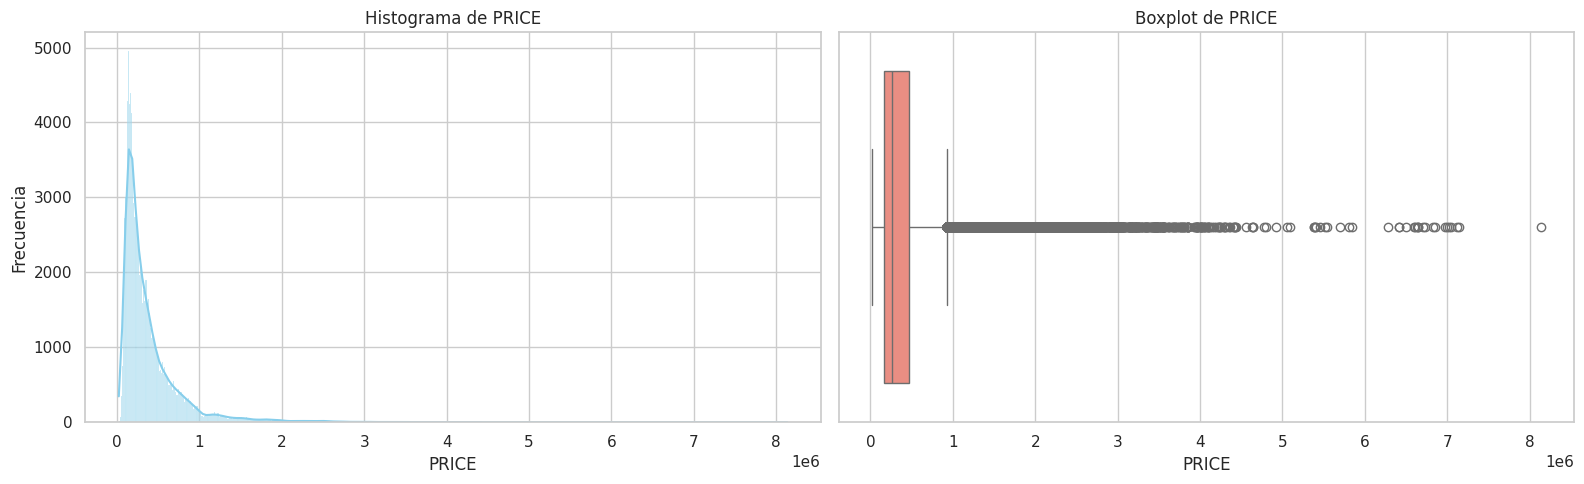

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración general de gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# ANÁLISIS DE LA VARIABLE PRICE
col = 'PRICE'

# Crear figura con dos subgráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histograma
sns.histplot(df[col].dropna(), kde=True, ax=axes[0], color="skyblue")
axes[0].set_title(f"Histograma de {col}")
axes[0].set_xlabel(col)
axes[0].set_ylabel("Frecuencia")

# Boxplot
sns.boxplot(x=df[col].dropna(), ax=axes[1], color="salmon")
axes[1].set_title(f"Boxplot de {col}")
axes[1].set_xlabel(col)

plt.tight_layout()
plt.show()

In [ ]:
# Encontrar el registro con el valor máximo de PRICE
max_price = 8.133000e+06
max_price_row = df[df['PRICE'] == max_price]

# Verificar si se encontró el registro
if not max_price_row.empty:
    print("Registro con el valor máximo de PRICE (8,133,000):")
    print(max_price_row)
else:
    print(f"No se encontró un registro con PRICE igual a {max_price}. Verifica el valor o el DataFrame.")

Registro con el valor máximo de PRICE (8,133,000):
       PERIOD      PRICE    UNITPRICE  CONSTRUCTEDAREA  ROOMNUMBER  \
56065  201812  8133000.0  8707.708779              934           8   

       BATHNUMBER  HASTERRACE  HASLIFT  HASAIRCONDITIONING  AMENITYID  ...  \
56065          10           0        0                   0          3  ...   

       CADDWELLINGCOUNT  CADASTRALQUALITYID  BUILTTYPEID_1  BUILTTYPEID_2  \
56065                 2                   2              0              0   

       BUILTTYPEID_3  DISTANCE_TO_CITY_CENTER  DISTANCE_TO_METRO  \
56065              1                 3.252209           0.507632   

       DISTANCE_TO_CASTELLANA  LONGITUDE  LATITUDE  
56065                0.123339  -3.690056  40.44387  

[1 rows x 40 columns]


Variable constructed area

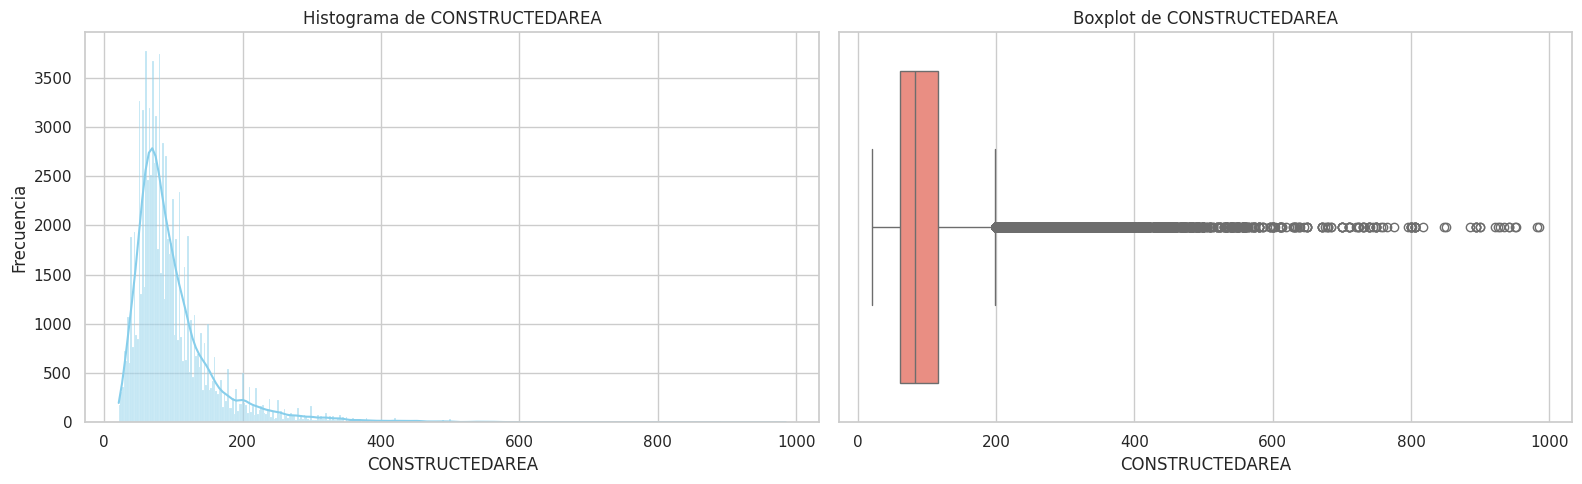

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Configuración general de gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# ANÁLISIS DE LA VARIABLE PRICE
col = 'CONSTRUCTEDAREA'

# Crear figura con dos subgráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histograma
sns.histplot(df[col].dropna(), kde=True, ax=axes[0], color="skyblue")
axes[0].set_title(f"Histograma de {col}")
axes[0].set_xlabel(col)
axes[0].set_ylabel("Frecuencia")

# Boxplot
sns.boxplot(x=df[col].dropna(), ax=axes[1], color="salmon")
axes[1].set_title(f"Boxplot de {col}")
axes[1].set_xlabel(col)

plt.tight_layout()
plt.show()

Variable BATHNUMBER

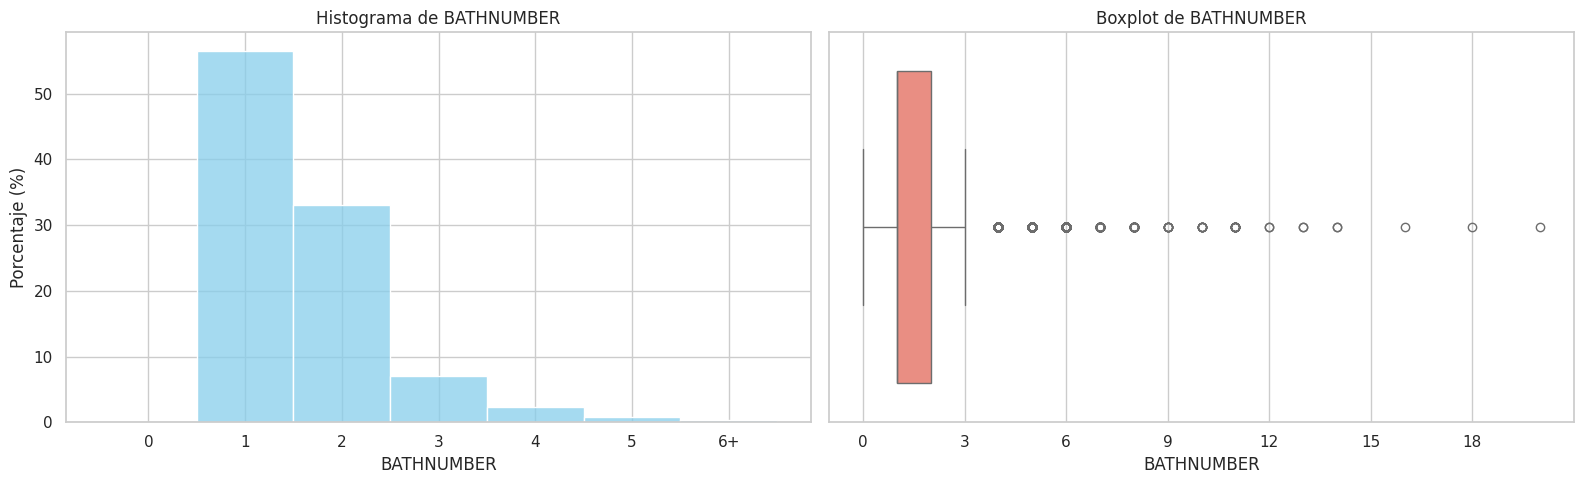

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Asegúrate de tener cargado tu DataFrame como `df`

# Configuración general de gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# ANÁLISIS DE LA VARIABLE BATHNUMBER
col = 'BATHNUMBER'

# Crear una copia de la columna y agrupar valores > 6
df_temp = df[[col]].copy()
df_temp['BATHNUMBER_CATEG'] = df_temp[col].apply(lambda x: str(x) if x <= 5 else '6+' if pd.notnull(x) else x)

# Definir el orden explícito de las categorías como tipo categórico
category_order = ['0', '1', '2', '3', '4', '5', '6+']
df_temp['BATHNUMBER_CATEG'] = pd.Categorical(df_temp['BATHNUMBER_CATEG'], categories=category_order, ordered=True)

# Crear figura con dos subgráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histograma con porcentajes y orden explícito
sns.histplot(data=df_temp, x='BATHNUMBER_CATEG', ax=axes[0], color="skyblue", stat="percent")
axes[0].set_title(f"Histograma de {col}")
axes[0].set_xlabel(col)
axes[0].set_ylabel("Porcentaje (%)")

# Boxplot de la variable original con ticks de 3 en 3
sns.boxplot(x=df[col].dropna(), ax=axes[1], color="salmon")
axes[1].set_title(f"Boxplot de {col}")
axes[1].set_xlabel(col)
# Ajustar los ticks del eje x a valores enteros de 3 en 3
min_val = int(df[col].dropna().min())
max_val = int(df[col].dropna().max())
integer_ticks = range(min_val - (min_val % 3), max_val + 1, 3)
axes[1].set_xticks(integer_ticks)

plt.tight_layout()
plt.show()

In [ ]:
# Encontrar el registro con el valor máximo de PRICE
max_bath = 20
max_bath_row = df[df['BATHNUMBER'] == max_bath]

# Verificar si se encontró el registro
if not max_bath_row.empty:
    print("Registro con el valor máximo de PRICE (8,133,000):")
    print(max_bath_row)
else:
    print(f"No se encontró un registro con PRICE igual a {max_bath_row}. Verifica el valor o el DataFrame.")

Registro con el valor máximo de PRICE (8,133,000):
       PERIOD     PRICE    UNITPRICE  CONSTRUCTEDAREA  ROOMNUMBER  BATHNUMBER  \
68890  201806  850000.0  1416.666667              600          20          20   

       HASTERRACE  HASLIFT  HASAIRCONDITIONING  AMENITYID  ...  \
68890           0        0                   1          3  ...   

       CADDWELLINGCOUNT  CADASTRALQUALITYID  BUILTTYPEID_1  BUILTTYPEID_2  \
68890                43                   3              0              1   

       BUILTTYPEID_3  DISTANCE_TO_CITY_CENTER  DISTANCE_TO_METRO  \
68890              0                 2.386553           0.319877   

       DISTANCE_TO_CASTELLANA  LONGITUDE   LATITUDE  
68890                1.130627  -3.678763  40.406766  

[1 rows x 40 columns]


Variable ROOMNUMBER

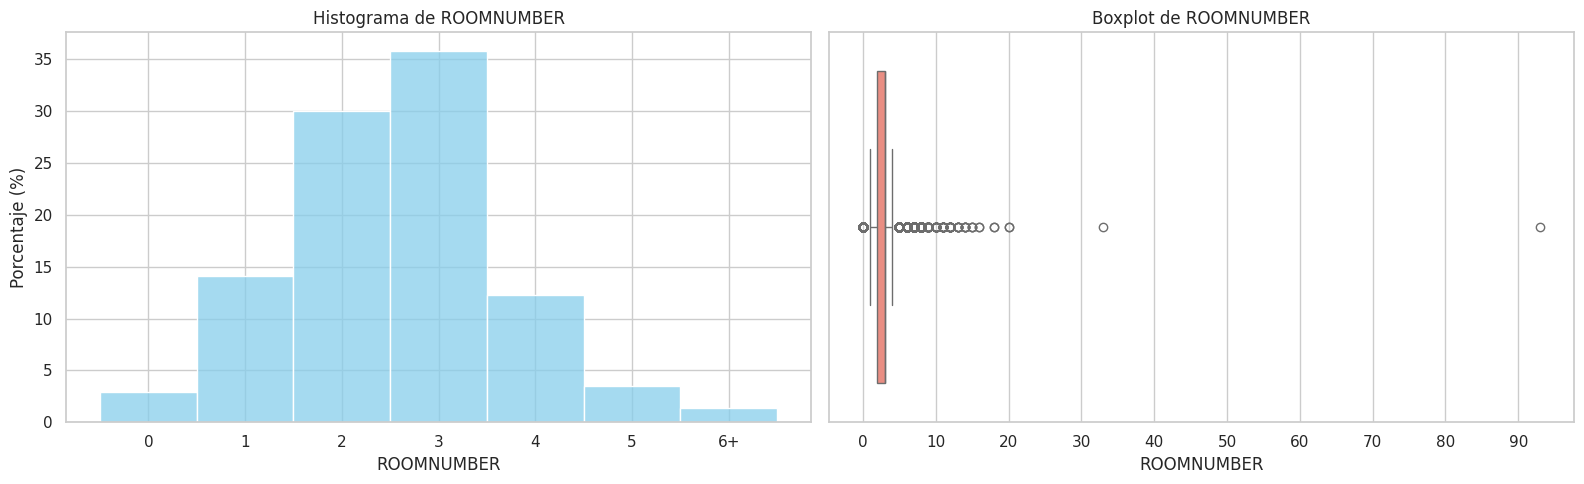

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuración general de gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# ANÁLISIS DE LA VARIABLE ROOMNUMBER
col = 'ROOMNUMBER'

# Crear una copia de la columna y agrupar valores > 6
df_temp = df[[col]].copy()
df_temp['ROOMNUMBER_CATEG'] = df_temp[col].apply(lambda x: str(x) if x <= 5 else '6+' if pd.notnull(x) else x)

# Definir el orden explícito de las categorías como tipo categórico
category_order = ['0', '1', '2', '3', '4', '5', '6+']
df_temp['ROOMNUMBER_CATEG'] = pd.Categorical(df_temp['ROOMNUMBER_CATEG'], categories=category_order, ordered=True)

# Crear figura con dos subgráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histograma con porcentajes y orden explícito
sns.histplot(data=df_temp, x='ROOMNUMBER_CATEG', ax=axes[0], color="skyblue", stat="percent")
axes[0].set_title(f"Histograma de {col}")
axes[0].set_xlabel(col)
axes[0].set_ylabel("Porcentaje (%)")

# Boxplot de la variable original con ticks de 3 en 3
sns.boxplot(x=df[col].dropna(), ax=axes[1], color="salmon")
axes[1].set_title(f"Boxplot de {col}")
axes[1].set_xlabel(col)
# Ajustar los ticks del eje x a valores enteros de 3 en 3
min_val = int(df[col].dropna().min())
max_val = int(df[col].dropna().max())
integer_ticks = range(min_val - (min_val % 3), max_val + 1, 10)
axes[1].set_xticks(integer_ticks)

plt.tight_layout()
plt.show()

In [11]:
# Encontrar el registro con ROOMNUMBER == 93
max_room_number = 93
max_room_number_row = df[df['ROOMNUMBER'] == max_room_number]

# Verificar si se encontró el registro
if not max_room_number_row.empty:
    print("Registro con ROOMNUMBER == 93:")
    print(max_room_number_row)
else:
    print(f"No se encontró un registro con ROOMNUMBER igual a {max_room_number}. Verifica el valor o el DataFrame.")

Registro con ROOMNUMBER == 93:
       PERIOD     PRICE    UNITPRICE  CONSTRUCTEDAREA  ROOMNUMBER  BATHNUMBER  \
17639  201803  450000.0  3781.512605              119          93           2   

       HASTERRACE  HASLIFT  HASAIRCONDITIONING  AMENITYID  ...  \
17639           1        1                   1          3  ...   

       CADDWELLINGCOUNT  CADASTRALQUALITYID  BUILTTYPEID_1  BUILTTYPEID_2  \
17639               421                   4              0              0   

       BUILTTYPEID_3  DISTANCE_TO_CITY_CENTER  DISTANCE_TO_METRO  \
17639              1                 7.020016           0.197061   

       DISTANCE_TO_CASTELLANA  LONGITUDE  LATITUDE  
17639                 5.85295  -3.623555  40.40096  

[1 rows x 40 columns]


In [12]:
# Encontrar el registro con ROOMNUMBER == 93
max_room_number = 93
max_room_number_row = df[df['ROOMNUMBER'] == max_room_number]

# Verificar si se encontró el registro
if not max_room_number_row.empty:

    # Eliminar el registro con ROOMNUMBER == 93
    df = df[df['ROOMNUMBER'] != max_room_number].reset_index(drop=True)
    print(f"\nRegistro(s) con ROOMNUMBER == {max_room_number} eliminado(s).")
    print("Nuevo tamaño de df:", df.shape)
else:
    print(f"No se encontró un registro con ROOMNUMBER igual a {max_room_number}. Verifica el valor o el DataFrame.")


Registro(s) con ROOMNUMBER == 93 eliminado(s).
Nuevo tamaño de df: (94814, 40)


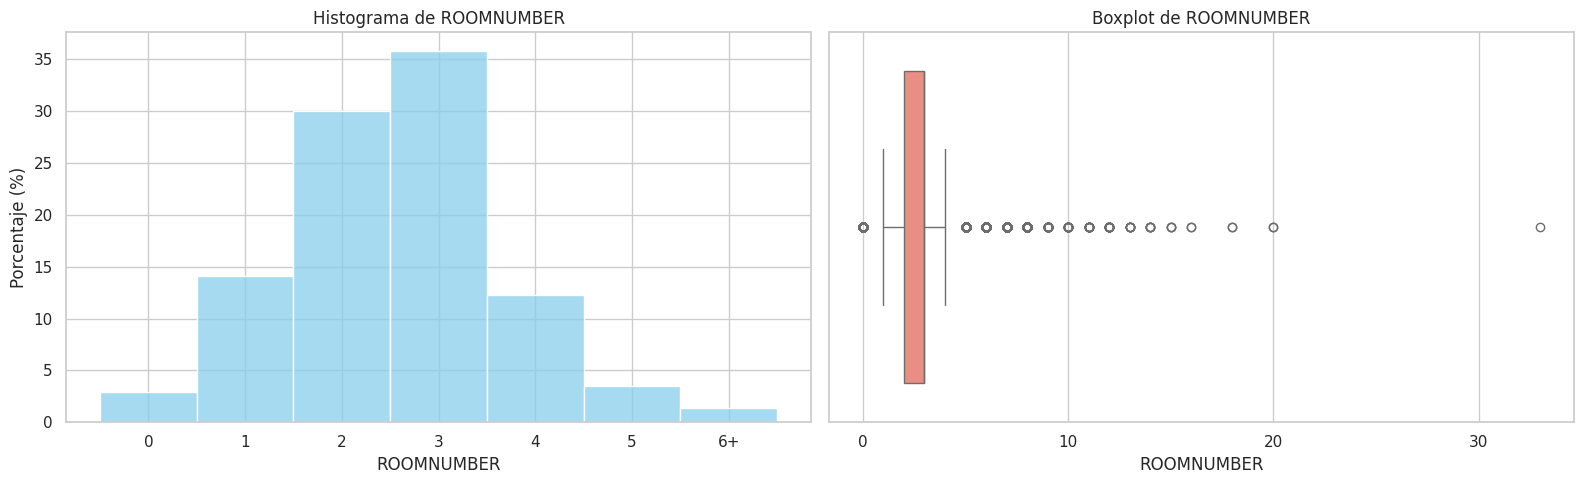

In [ ]:

# Configuración general de gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# ANÁLISIS DE LA VARIABLE ROOMNUMBER
col = 'ROOMNUMBER'

# Crear una copia de la columna y agrupar valores > 6
df_temp = df[[col]].copy()
df_temp['ROOMNUMBER_CATEG'] = df_temp[col].apply(lambda x: str(x) if x <= 5 else '6+' if pd.notnull(x) else x)

# Definir el orden explícito de las categorías como tipo categórico
category_order = ['0', '1', '2', '3', '4', '5', '6+']
df_temp['ROOMNUMBER_CATEG'] = pd.Categorical(df_temp['ROOMNUMBER_CATEG'], categories=category_order, ordered=True)

# Crear figura con dos subgráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histograma con porcentajes y orden explícito
sns.histplot(data=df_temp, x='ROOMNUMBER_CATEG', ax=axes[0], color="skyblue", stat="percent")
axes[0].set_title(f"Histograma de {col}")
axes[0].set_xlabel(col)
axes[0].set_ylabel("Porcentaje (%)")

# Boxplot de la variable original con ticks de 3 en 3
sns.boxplot(x=df[col].dropna(), ax=axes[1], color="salmon")
axes[1].set_title(f"Boxplot de {col}")
axes[1].set_xlabel(col)
# Ajustar los ticks del eje x a valores enteros de 3 en 3
min_val = int(df[col].dropna().min())
max_val = int(df[col].dropna().max())
integer_ticks = range(min_val - (min_val % 3), max_val + 1, 10)
axes[1].set_xticks(integer_ticks)

plt.tight_layout()
plt.show()

Variable HASAIRCONDITIONING y HASLIFT                         

/tmp/ipython-input-33-625279172.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="pastel")


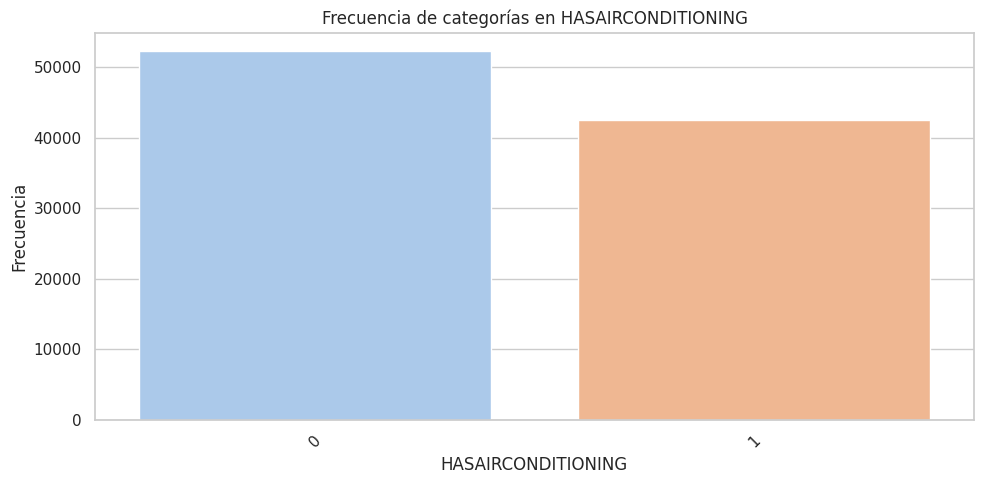

/tmp/ipython-input-33-625279172.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="pastel")


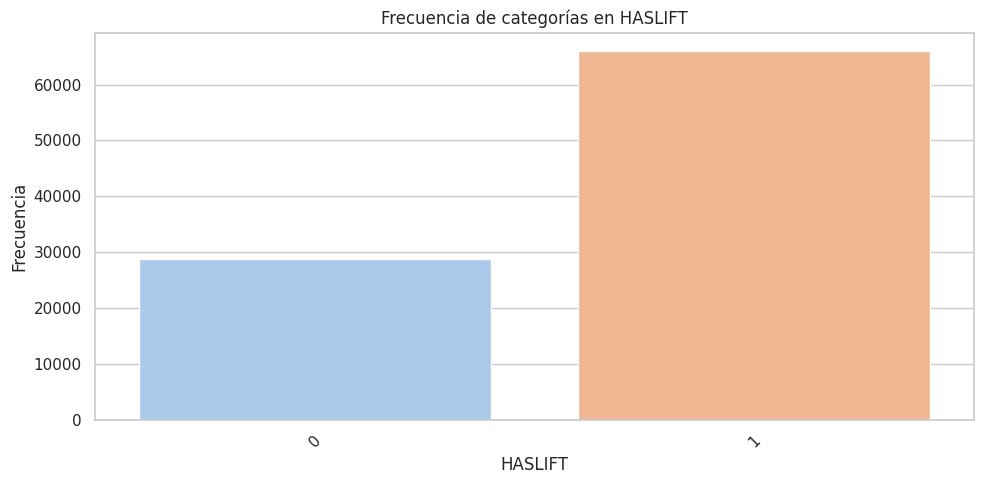

In [ ]:
vars_categoricas = ['HASAIRCONDITIONING', 'HASLIFT']

# Configuración general de gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# ANÁLISIS DE VARIABLES CATEGÓRICAS
for col in vars_categoricas:
    plt.figure(figsize=(10, 5))

    # Si hay muchas categorías, solo mostramos las más frecuentes
    if df[col].nunique() > 15:
        top_cats = df[col].value_counts().nlargest(15)
        sns.barplot(x=top_cats.index.astype(str), y=top_cats.values, palette="viridis")
        plt.title(f"Top 15 categorías más frecuentes de {col}")
    else:
        sns.countplot(x=col, data=df, palette="pastel")
        plt.title(f"Frecuencia de categorías en {col}")

    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

# Pre-procesamiento de los datos

En primer lugar, se comprueba si existen columnas con datos faltantes

In [13]:
df.isna().sum()

,0
PERIOD,0
PRICE,0
UNITPRICE,0
CONSTRUCTEDAREA,0
ROOMNUMBER,0
BATHNUMBER,0
HASTERRACE,0
HASLIFT,0
HASAIRCONDITIONING,0
AMENITYID,0


In [14]:
df_corr = df[['CONSTRUCTIONYEAR', 'CADCONSTRUCTIONYEAR']].dropna()
pearson_corr = df_corr['CONSTRUCTIONYEAR'].corr(df_corr['CADCONSTRUCTIONYEAR'], method='pearson')
spearman_corr = df_corr['CONSTRUCTIONYEAR'].corr(df_corr['CADCONSTRUCTIONYEAR'], method='spearman')
kendall_corr = df_corr['CONSTRUCTIONYEAR'].corr(df_corr['CADCONSTRUCTIONYEAR'], method='kendall')
print(f"Correlación de Pearson:  {pearson_corr:.3f}")
print(f"Correlación de Spearman: {spearman_corr:.3f}")
print(f"Correlación de Kendall:  {kendall_corr:.3f}")

Correlación de Pearson:  0.551
Correlación de Spearman: 0.992
Correlación de Kendall:  0.988


La columna "CONTRUCTIONYEAR" tiene 55.873 missing de 94.815 (58,93%), por lo que se va a eliminar la columna. Sobre el resto de datos faltantes, se va a imputar a través de la mediana.

Posteriormente, se van a eliminar las variables "assetid" por ser únicamente un identificador, "unitprice", porque es el PRICE dividido por los m2, por lo que no tiene sentido mantenerla como variable explicativa, "period", porque todos los pisos son de la misma fecha y "geometry", porque son los datos de longitud y latitud combinados.

In [16]:
madrid_sale_df_2 = df.drop(columns=["CONSTRUCTIONYEAR", "UNITPRICE", "PERIOD"])

Ahora imputamos los missing a través de los k vecinos

In [17]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
madrid_sale_df_2_imputed = pd.DataFrame(
    imputer.fit_transform(madrid_sale_df_2),
    columns=madrid_sale_df_2.columns,
    index=madrid_sale_df_2.index
)



In [18]:
#Se comprueba si hay missing
madrid_sale_df_2_imputed.isna().sum()

,0
PRICE,0
CONSTRUCTEDAREA,0
ROOMNUMBER,0
BATHNUMBER,0
HASTERRACE,0
HASLIFT,0
HASAIRCONDITIONING,0
AMENITYID,0
HASPARKINGSPACE,0
ISPARKINGSPACEINCLUDEDINPRICE,0


Una vez analizados los missing de cada variable, se va a analizar si existen valores outlier en cada variable. Se va a considerar outlier todo aquel que esté fuera de $[Q1 - 1.5*IQR, Q3 + 1.5*IQR]$

In [19]:
# Paso 2: Identificar outliers usando IQR
def detect_outliers_iqr(df, columns):
    outliers_dict = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outliers_dict[col] = len(outliers)
    return outliers_dict

# Identify continuous variables (numerical columns with more than 10 unique values)
continuous_cols = [
    col for col in madrid_sale_df_2_imputed.select_dtypes(include=['number']).columns
    if madrid_sale_df_2_imputed[col].nunique(dropna=True) > 10 and col != 'CADASTRALQUALITYID'
]
# Detect outliers in continuous columns
outliers_summary = detect_outliers_iqr(madrid_sale_df_2_imputed, continuous_cols)

print("Número de outliers por columna:")
for col, count in outliers_summary.items():
    print(f"{col}: {count} outliers")

Número de outliers por columna:
PRICE: 6782 outliers
CONSTRUCTEDAREA: 6957 outliers
ROOMNUMBER: 7419 outliers
BATHNUMBER: 3118 outliers
PARKINGSPACEPRICE: 2191 outliers
FLOORCLEAN: 2317 outliers
CADCONSTRUCTIONYEAR: 6381 outliers
CADMAXBUILDINGFLOOR: 4055 outliers
CADDWELLINGCOUNT: 10854 outliers
DISTANCE_TO_CITY_CENTER: 800 outliers
DISTANCE_TO_METRO: 6923 outliers
DISTANCE_TO_CASTELLANA: 2809 outliers
LONGITUDE: 4201 outliers
LATITUDE: 182 outliers


Ahora se divide en train/test.

In [21]:
from sklearn.model_selection import train_test_split

# Dividir en 80% train y 20% test (puedes ajustar test_size según necesites)
madrid_sale_train_df, madrid_sale_test_df = train_test_split(
    madrid_sale_df_2_imputed,
    test_size=0.2,
    random_state=42  # para reproducibilidad
)


Una vez se ha dividido en train/test, se va a realizar un tratamiento con los outliers.  Para mitigar el impacto de los valores atípicos en las variables continuas, se ha optado por aplicar una técnica de winsorización al 1% y 99%. Esta transformación conserva la estructura general de los datos, sustituyendo únicamente los valores extremos por los percentiles definidos. Se ha aplicado exclusivamente a aquellas numéricas. Esta aproximación permite preservar la información relevante de la muestra, evitando tanto la eliminación como la distorsión excesiva de los datos. Se va a aplicar en primer lugar al train y despues al test.

In [22]:
# Identificar outliers usando IQR
def detect_outliers_iqr(df, columns):
    outliers_dict = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outliers_dict[col] = len(outliers)
    return outliers_dict

# Identify continuous variables (numerical columns with more than 10 unique values)
continuous_cols = [
    col for col in madrid_sale_train_df.select_dtypes(include=['number']).columns
    if madrid_sale_train_df[col].nunique(dropna=True) > 10 and col != 'CADASTRALQUALITYID'
]

# Detect outliers in continuous columns
outliers_summary = detect_outliers_iqr(madrid_sale_train_df, continuous_cols)

print("Número de outliers por columna:")
for col, count in outliers_summary.items():
    print(f"{col}: {count} outliers")

Número de outliers por columna:
PRICE: 5353 outliers
CONSTRUCTEDAREA: 5048 outliers
ROOMNUMBER: 5872 outliers
BATHNUMBER: 2445 outliers
PARKINGSPACEPRICE: 1779 outliers
FLOORCLEAN: 1822 outliers
CADCONSTRUCTIONYEAR: 5083 outliers
CADMAXBUILDINGFLOOR: 3250 outliers
CADDWELLINGCOUNT: 8732 outliers
DISTANCE_TO_CITY_CENTER: 623 outliers
DISTANCE_TO_METRO: 5548 outliers
DISTANCE_TO_CASTELLANA: 2269 outliers
LONGITUDE: 3416 outliers
LATITUDE: 158 outliers


In [23]:
# Mostrar mínimo y máximo de cada columna continua
min_max = madrid_sale_train_df[continuous_cols].agg(['min', 'max']).T
print(min_max)


                                  min           max
PRICE                    21000.000000  7.138000e+06
CONSTRUCTEDAREA             21.000000  9.850000e+02
ROOMNUMBER                   0.000000  3.300000e+01
BATHNUMBER                   0.000000  2.000000e+01
PARKINGSPACEPRICE            1.000000  9.250010e+05
FLOORCLEAN                  -1.000000  1.100000e+01
CADCONSTRUCTIONYEAR       1623.000000  2.018000e+03
CADMAXBUILDINGFLOOR          0.000000  2.600000e+01
CADDWELLINGCOUNT             1.000000  1.499000e+03
DISTANCE_TO_CITY_CENTER      0.015374  4.157526e+02
DISTANCE_TO_METRO            0.001416  3.994774e+02
DISTANCE_TO_CASTELLANA       0.001435  4.128037e+02
LONGITUDE                   -3.833611 -2.753303e+00
LATITUDE                    36.756391  4.052064e+01


In [24]:
# Crear copia del DataFrame original para preservar datos
madrid_sale_train_df_out = madrid_sale_train_df.copy()

# Paso 2: Aplicar winsorización manual (recorte) al 1%-99% percentil
for col in continuous_cols:
    if madrid_sale_train_df_out[col].isnull().sum() == 0:  # solo si no hay nulos
        lower = madrid_sale_train_df_out[col].quantile(0.01)
        upper = madrid_sale_train_df_out[col].quantile(0.99)
        original_min, original_max = madrid_sale_train_df_out[col].min(), madrid_sale_train_df_out[col].max()
        madrid_sale_train_df_out[col] = madrid_sale_train_df_out[col].clip(lower, upper)
        print(f"Winsorizada {col} | Min: {original_min} → {madrid_sale_train_df_out[col].min()} | Max: {original_max} → {madrid_sale_train_df_out[col].max()}")


Winsorizada PRICE | Min: 21000.0 → 71000.0 | Max: 7138000.0 → 2178500.0
Winsorizada CONSTRUCTEDAREA | Min: 21.0 → 30.0 | Max: 985.0 → 366.0
Winsorizada ROOMNUMBER | Min: 0.0 → 0.0 | Max: 33.0 → 6.0
Winsorizada BATHNUMBER | Min: 0.0 → 1.0 | Max: 20.0 → 5.0
Winsorizada PARKINGSPACEPRICE | Min: 1.0 → 1.0 | Max: 925001.0 → 30001.0
Winsorizada FLOORCLEAN | Min: -1.0 → -1.0 | Max: 11.0 → 11.0
Winsorizada CADCONSTRUCTIONYEAR | Min: 1623.0 → 1888.0 | Max: 2018.0 → 2018.0
Winsorizada CADMAXBUILDINGFLOOR | Min: 0.0 → 2.0 | Max: 26.0 → 16.0
Winsorizada CADDWELLINGCOUNT | Min: 1.0 → 2.0 | Max: 1499.0 → 271.0
Winsorizada DISTANCE_TO_CITY_CENTER | Min: 0.015374143253467792 → 0.38799978600884644 | Max: 415.7525844073621 → 11.690025472429028
Winsorizada DISTANCE_TO_METRO | Min: 0.0014160886550168479 → 0.044406525327645635 | Max: 399.47736648319045 → 4.035511759241687
Winsorizada DISTANCE_TO_CASTELLANA | Min: 0.0014350974069677167 → 0.06757978367126469 | Max: 412.80368844951164 → 9.407324564812095
Wins

In [25]:
#Guardamos estas variables para el desarrollo de la aplicación
import joblib

q_low = madrid_sale_train_df.quantile(0.01)
q_high = madrid_sale_train_df.quantile(0.99)

joblib.dump(q_low, "percentil_01.pkl")
joblib.dump(q_high, "percentil_99.pkl")


['percentil_99.pkl']

In [26]:
#Identificar outliers usando IQR
def detect_outliers_iqr(df, columns):
    outliers_dict = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outliers_dict[col] = len(outliers)
    return outliers_dict

# Detect outliers in continuous columns
outliers_summary = detect_outliers_iqr(madrid_sale_train_df_out, continuous_cols)

print("Número de outliers por columna:")
for col, count in outliers_summary.items():
    print(f"{col}: {count} outliers")

Número de outliers por columna:
PRICE: 5353 outliers
CONSTRUCTEDAREA: 5048 outliers
ROOMNUMBER: 5872 outliers
BATHNUMBER: 2445 outliers
PARKINGSPACEPRICE: 1779 outliers
FLOORCLEAN: 1822 outliers
CADCONSTRUCTIONYEAR: 5083 outliers
CADMAXBUILDINGFLOOR: 3167 outliers
CADDWELLINGCOUNT: 8732 outliers
DISTANCE_TO_CITY_CENTER: 0 outliers
DISTANCE_TO_METRO: 5548 outliers
DISTANCE_TO_CASTELLANA: 2269 outliers
LONGITUDE: 3416 outliers
LATITUDE: 0 outliers


In [27]:
min_max = madrid_sale_train_df_out[continuous_cols].agg(['min', 'max']).T
print(min_max)

                                  min           max
PRICE                    71000.000000  2.178500e+06
CONSTRUCTEDAREA             30.000000  3.660000e+02
ROOMNUMBER                   0.000000  6.000000e+00
BATHNUMBER                   1.000000  5.000000e+00
PARKINGSPACEPRICE            1.000000  3.000100e+04
FLOORCLEAN                  -1.000000  1.100000e+01
CADCONSTRUCTIONYEAR       1888.000000  2.018000e+03
CADMAXBUILDINGFLOOR          2.000000  1.600000e+01
CADDWELLINGCOUNT             2.000000  2.710000e+02
DISTANCE_TO_CITY_CENTER      0.388000  1.169003e+01
DISTANCE_TO_METRO            0.044407  4.035512e+00
DISTANCE_TO_CASTELLANA       0.067580  9.407325e+00
LONGITUDE                   -3.779563 -3.581081e+00
LATITUDE                    40.344092  4.049844e+01


Una vez aplicado al data set de entrenamiento, se va a aplicar al de test. Se va a observar que también hay un cambio

In [28]:
#Identificar outliers usando IQR
def detect_outliers_iqr(df, columns):
    outliers_dict = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outliers_dict[col] = len(outliers)
    return outliers_dict

continuous_cols = [
    col for col in madrid_sale_test_df.select_dtypes(include=['number']).columns
    if madrid_sale_test_df[col].nunique(dropna=True) > 10 and col != 'CADASTRALQUALITYID'
]

# Detect outliers in continuous columns
outliers_summary = detect_outliers_iqr(madrid_sale_test_df, continuous_cols)

print("Número de outliers por columna:")
for col, count in outliers_summary.items():
    print(f"{col}: {count} outliers")

Número de outliers por columna:
PRICE: 1397 outliers
CONSTRUCTEDAREA: 1449 outliers
ROOMNUMBER: 1547 outliers
BATHNUMBER: 673 outliers
PARKINGSPACEPRICE: 412 outliers
FLOORCLEAN: 495 outliers
CADCONSTRUCTIONYEAR: 1311 outliers
CADMAXBUILDINGFLOOR: 1498 outliers
CADDWELLINGCOUNT: 2290 outliers
DISTANCE_TO_CITY_CENTER: 163 outliers
DISTANCE_TO_METRO: 1387 outliers
DISTANCE_TO_CASTELLANA: 544 outliers
LONGITUDE: 787 outliers
LATITUDE: 21 outliers


In [29]:
min_max = madrid_sale_test_df[continuous_cols].agg(['min', 'max']).T
print(min_max)

                                  min           max
PRICE                    33000.000000  8.133000e+06
CONSTRUCTEDAREA             21.000000  9.510000e+02
ROOMNUMBER                   0.000000  1.600000e+01
BATHNUMBER                   0.000000  1.400000e+01
PARKINGSPACEPRICE            1.000000  2.500010e+05
FLOORCLEAN                  -1.000000  1.100000e+01
CADCONSTRUCTIONYEAR       1623.000000  2.018000e+03
CADMAXBUILDINGFLOOR          0.000000  2.600000e+01
CADDWELLINGCOUNT             1.000000  7.240000e+02
DISTANCE_TO_CITY_CENTER      0.007647  1.414993e+01
DISTANCE_TO_METRO            0.002589  9.341096e+00
DISTANCE_TO_CASTELLANA       0.004269  1.256402e+01
LONGITUDE                   -3.832707 -3.541029e+00
LATITUDE                    40.328682  4.052006e+01


In [30]:
# Crear copia del DataFrame de test para no modificar el original
madrid_sale_test_df_out = madrid_sale_test_df.copy()

# Aplicar winsorización usando los límites calculados en el train
for col in continuous_cols:
    if madrid_sale_test_df_out[col].isnull().sum() == 0:  # solo si no hay nulos en test
        lower = madrid_sale_train_df[col].quantile(0.01)  # percentil 1 del train
        upper = madrid_sale_train_df[col].quantile(0.99)  # percentil 99 del train
        original_min, original_max = madrid_sale_test_df_out[col].min(), madrid_sale_test_df_out[col].max()
        madrid_sale_test_df_out[col] = madrid_sale_test_df_out[col].clip(lower, upper)
        print(f"Winsorizada {col} (test) | Min: {original_min} → {madrid_sale_test_df_out[col].min()} | Max: {original_max} → {madrid_sale_test_df_out[col].max()}")


Winsorizada PRICE (test) | Min: 33000.0 → 71000.0 | Max: 8133000.0 → 2178500.0
Winsorizada CONSTRUCTEDAREA (test) | Min: 21.0 → 30.0 | Max: 951.0 → 366.0
Winsorizada ROOMNUMBER (test) | Min: 0.0 → 0.0 | Max: 16.0 → 6.0
Winsorizada BATHNUMBER (test) | Min: 0.0 → 1.0 | Max: 14.0 → 5.0
Winsorizada PARKINGSPACEPRICE (test) | Min: 1.0 → 1.0 | Max: 250001.0 → 30001.0
Winsorizada FLOORCLEAN (test) | Min: -1.0 → -1.0 | Max: 11.0 → 11.0
Winsorizada CADCONSTRUCTIONYEAR (test) | Min: 1623.0 → 1888.0 | Max: 2018.0 → 2018.0
Winsorizada CADMAXBUILDINGFLOOR (test) | Min: 0.0 → 2.0 | Max: 26.0 → 16.0
Winsorizada CADDWELLINGCOUNT (test) | Min: 1.0 → 2.0 | Max: 724.0 → 271.0
Winsorizada DISTANCE_TO_CITY_CENTER (test) | Min: 0.007646571604588598 → 0.38799978600884644 | Max: 14.149930295864683 → 11.690025472429028
Winsorizada DISTANCE_TO_METRO (test) | Min: 0.0025889037755578125 → 0.044406525327645635 | Max: 9.341095836675143 → 4.035511759241687
Winsorizada DISTANCE_TO_CASTELLANA (test) | Min: 0.004269475

In [31]:
#Identificar outliers usando IQR
def detect_outliers_iqr(df, columns):
    outliers_dict = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outliers_dict[col] = len(outliers)
    return outliers_dict

# Detect outliers in continuous columns
outliers_summary = detect_outliers_iqr(madrid_sale_test_df_out, continuous_cols)

print("Número de outliers por columna:")
for col, count in outliers_summary.items():
    print(f"{col}: {count} outliers")

Número de outliers por columna:
PRICE: 1397 outliers
CONSTRUCTEDAREA: 1449 outliers
ROOMNUMBER: 1547 outliers
BATHNUMBER: 673 outliers
PARKINGSPACEPRICE: 412 outliers
FLOORCLEAN: 495 outliers
CADCONSTRUCTIONYEAR: 1311 outliers
CADMAXBUILDINGFLOOR: 1356 outliers
CADDWELLINGCOUNT: 2290 outliers
DISTANCE_TO_CITY_CENTER: 0 outliers
DISTANCE_TO_METRO: 1387 outliers
DISTANCE_TO_CASTELLANA: 544 outliers
LONGITUDE: 787 outliers
LATITUDE: 0 outliers


In [32]:
min_max = madrid_sale_test_df_out[continuous_cols].agg(['min', 'max']).T
print(min_max)

                                  min           max
PRICE                    71000.000000  2.178500e+06
CONSTRUCTEDAREA             30.000000  3.660000e+02
ROOMNUMBER                   0.000000  6.000000e+00
BATHNUMBER                   1.000000  5.000000e+00
PARKINGSPACEPRICE            1.000000  3.000100e+04
FLOORCLEAN                  -1.000000  1.100000e+01
CADCONSTRUCTIONYEAR       1888.000000  2.018000e+03
CADMAXBUILDINGFLOOR          2.000000  1.600000e+01
CADDWELLINGCOUNT             2.000000  2.710000e+02
DISTANCE_TO_CITY_CENTER      0.388000  1.169003e+01
DISTANCE_TO_METRO            0.044407  4.035512e+00
DISTANCE_TO_CASTELLANA       0.067580  9.407325e+00
LONGITUDE                   -3.779563 -3.581081e+00
LATITUDE                    40.344092  4.049844e+01


In [33]:
#Train
madrid_sale_train_df_obj=madrid_sale_train_df_out["PRICE"]
madrid_sale_train_df_expl = madrid_sale_train_df_out.drop(columns=["PRICE"])
#Test
madrid_sale_test_df_obj=madrid_sale_test_df_out["PRICE"]
madrid_sale_test_df_expl = madrid_sale_test_df_out.drop(columns=["PRICE"])

## PCA al conjunto de entrenamiento

En este punto, se va a aplicar PCA, que es una técnica que transforma un conjunto de variables posiblemente correlacionadas en un conjunto de variables no correlacionadas llamadas componentes principales. Estos componentes capturan la mayor parte de la variabilidad de los datos con menos dimensiones.

### PCA Lineal

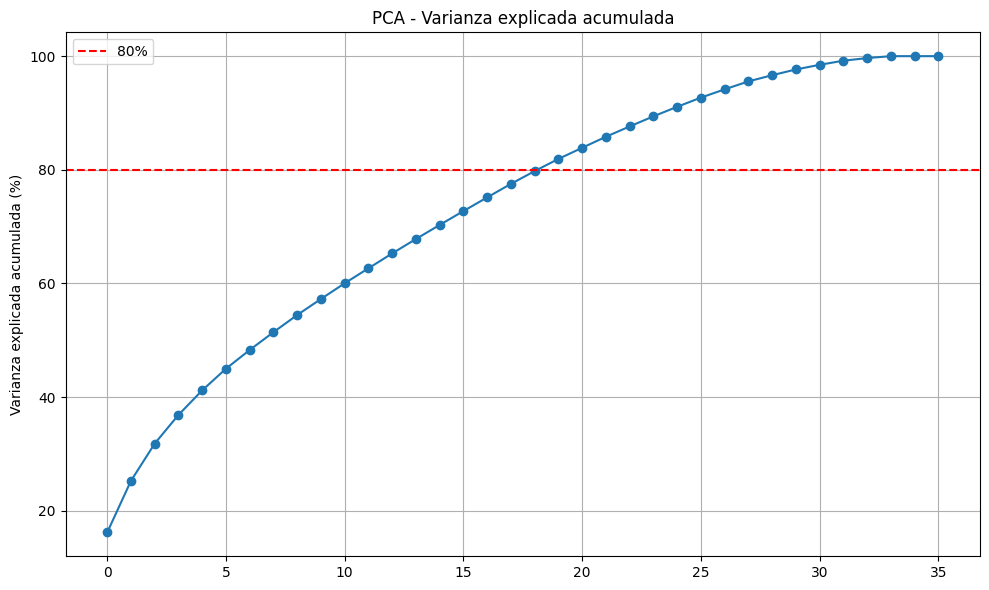

Componentes necesarias para explicar el 80% de la varianza: 20


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Selección del DataFrame ya preprocesado
df = madrid_sale_train_df_expl.copy()

# Paso 3: Estandarización de los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Paso 4: PCA clásico
pca = PCA()
pca.fit(df_scaled)

# Paso 5: Varianza explicada
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Gráfico de varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance * 100, marker='o')
plt.ylabel('Varianza explicada acumulada (%)')
plt.title('PCA - Varianza explicada acumulada')
plt.grid(True)
plt.axhline(80, color='red', linestyle='--', label='80%')
plt.legend()
plt.tight_layout()
plt.show()

# Paso 6: Cuántas componentes necesitamos para el 80%
n_components_90 = np.argmax(cumulative_variance >= 0.80) + 1
print(f"Componentes necesarias para explicar el 80% de la varianza: {n_components_90}")

### PCA con kernel

#### Núcleo Sigmoide

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Liberar memoria
gc.collect()

# Paso 1: Cargar y preparar los datos
df = madrid_sale_train_df_expl.copy().astype(np.float32)  # Reducir precisión
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Paso 2: KernelPCA
n_components = 20
kpca = KernelPCA(
    n_components=n_components,
    kernel='sigmoid',
    eigen_solver='randomized',
    n_jobs=-1,
    fit_inverse_transform=False
)
X_kpca = kpca.fit_transform(df_scaled)

# Paso 3: Calcular varianza explicada (estimada)
component_variances = np.var(X_kpca, axis=0)
explained_variance_ratio_kpca = component_variances / np.sum(component_variances)
cumulative_variance_kpca = np.cumsum(explained_variance_ratio_kpca)

# Paso 4: Tabla de varianza explicada
df_varianza = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(n_components)],
    'Varianza Explicada (%)': explained_variance_ratio_kpca * 100,
    'Varianza Acumulada (%)': cumulative_variance_kpca * 100
})

print("\nVarianza explicada por cada componente principal:")
print(df_varianza.round(2))

# Paso 5: Gráfico
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, n_components + 1), y=cumulative_variance_kpca * 100, marker='o')
plt.axhline(80, color='red', linestyle='--', label='80%')
plt.axhline(90, color='green', linestyle='--', label='90%')
plt.xticks(range(1, n_components + 1))
plt.xlabel('Número de componentes principales (Kernel PCA)')
plt.ylabel('Varianza explicada acumulada (%)')
plt.title('Kernel PCA (sigmoid) - Varianza explicada')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 6: Componentes necesarias para explicar el 80%
n_components_80 = np.argmax(cumulative_variance_kpca >= 0.80) + 1
print(f"\nComponentes necesarias para explicar el 80% de la varianza (estimado): {n_components_80}")


ValueError: There are significant negative eigenvalues (0.10991 of the maximum positive). Either the matrix is not PSD, or there was an issue while computing the eigendecomposition of the matrix.

#### Núcleo rbf


Varianza explicada por cada componente principal (Kernel RBF):
   Componente  Varianza Explicada (%)  Varianza Acumulada (%)
0         PC1                   15.67               15.670000
1         PC2                    8.27               23.940001
2         PC3                    7.15               31.090000
3         PC4                    6.02               37.110001
4         PC5                    4.24               41.349998
5         PC6                    3.98               45.330002
6         PC7                    3.43               48.759998
7         PC8                    3.35               52.110001
8         PC9                    2.87               54.980000
9        PC10                    2.78               57.759998
10       PC11                    2.61               60.380001
11       PC12                    2.55               62.930000
12       PC13                    2.51               65.430000
13       PC14                    2.38               67.809998
14    

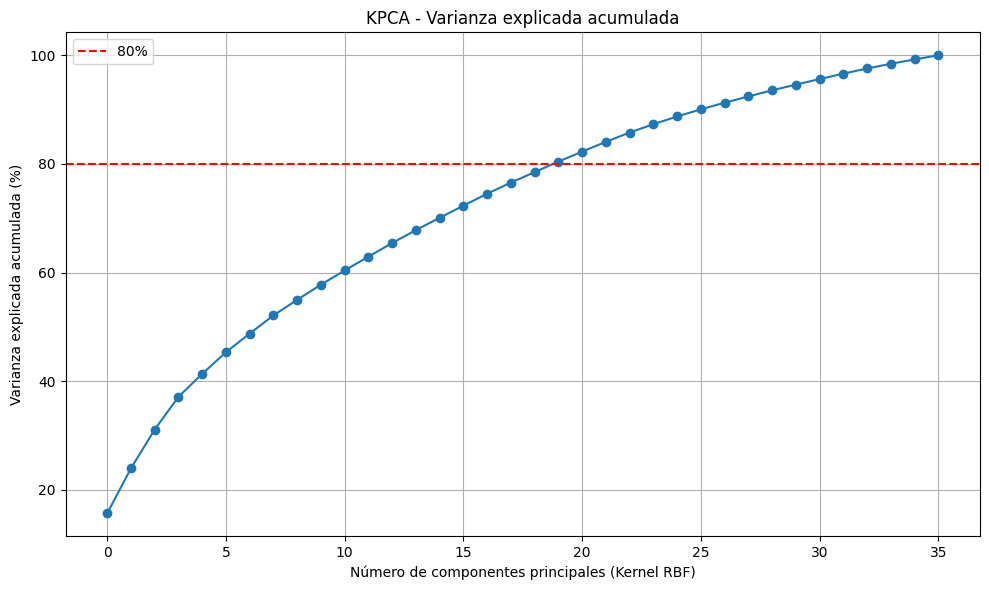


Componentes necesarias para explicar el 80% de la varianza (estimado): 20


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Liberar memoria
gc.collect()

# Paso 1: Cargar y preparar los datos
df = madrid_sale_train_df_expl.copy().astype(np.float32)  # Reducir precisión
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Paso 2: KernelPCA
n_components = 36
kpca = KernelPCA(
    n_components=n_components,
    kernel='rbf',  # Cambiado de 'sigmoid' a 'rbf'
    eigen_solver='randomized',
    n_jobs=-1,
    fit_inverse_transform=False
)
X_kpca = kpca.fit_transform(df_scaled)

# Paso 3: Calcular varianza explicada (estimada)
component_variances = np.var(X_kpca, axis=0)
explained_variance_ratio_kpca = component_variances / np.sum(component_variances)
cumulative_variance_kpca = np.cumsum(explained_variance_ratio_kpca)

# Paso 4: Tabla de varianza explicada
df_varianza = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(n_components)],
    'Varianza Explicada (%)': explained_variance_ratio_kpca * 100,
    'Varianza Acumulada (%)': cumulative_variance_kpca * 100
})

print("\nVarianza explicada por cada componente principal (Kernel RBF):")
print(df_varianza.round(2))


# Gráfico de varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_kpca * 100, marker='o')
plt.ylabel('Varianza explicada acumulada (%)')
plt.xlabel('Número de componentes principales (Kernel RBF)')
plt.title('KPCA - Varianza explicada acumulada')
plt.grid(True)
plt.axhline(80, color='red', linestyle='--', label='80%')
plt.legend()
plt.tight_layout()
plt.show()

# Paso 6: Componentes necesarias para explicar el 80%
n_components_80 = np.argmax(cumulative_variance_kpca >= 0.80) + 1
print(f"\nComponentes necesarias para explicar el 80% de la varianza (estimado): {n_components_80}")


#### Polinómico


Varianza explicada por cada componente principal (Kernel PCA - estimado):
   Componente  Varianza Explicada (%)  Varianza Acumulada (%)
0         PC1                   14.25               14.250000
1         PC2                    8.03               22.280001
2         PC3                    6.24               28.520000
3         PC4                    5.44               33.959999
4         PC5                    5.02               38.980000
5         PC6                    4.74               43.720001
6         PC7                    4.38               48.099998
7         PC8                    3.86               51.959999
8         PC9                    3.57               55.520000
9        PC10                    3.32               58.849998
10       PC11                    2.92               61.759998
11       PC12                    2.81               64.570000
12       PC13                    2.60               67.169998
13       PC14                    2.54               69.69

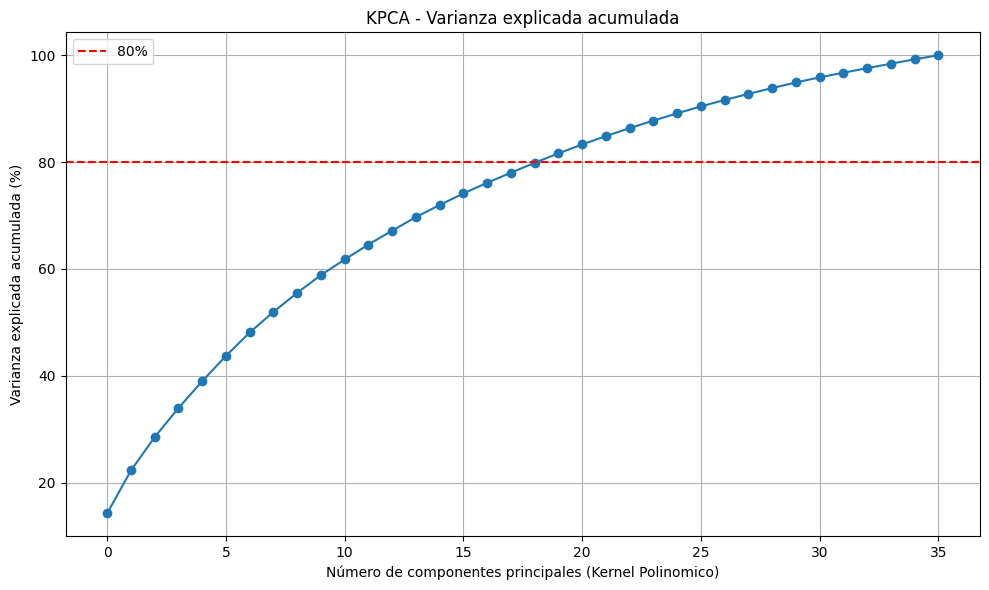


Componentes necesarias para explicar el 80% de la varianza (estimado): 20


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Liberar memoria
gc.collect()

#Cargar y preparar los datos
df = madrid_sale_train_df_expl.copy().astype(np.float32)  # Reducir precisión
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

#KernelPCA con kernel polinómico
n_components = 36
kpca = KernelPCA(
    n_components=n_components,
    kernel='poly',
    degree=3,
    coef0=0.5,
    gamma=0.01,
    eigen_solver='randomized',
    n_jobs=-1,
    fit_inverse_transform=False
)


X_kpca = kpca.fit_transform(df_scaled)

#Calcular varianza explicada (estimada)
component_variances = np.var(X_kpca, axis=0)
explained_variance_ratio_kpca = component_variances / np.sum(component_variances)
cumulative_variance_kpca = np.cumsum(explained_variance_ratio_kpca)

#Tabla de varianza explicada
df_varianza = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(n_components)],
    'Varianza Explicada (%)': explained_variance_ratio_kpca * 100,
    'Varianza Acumulada (%)': cumulative_variance_kpca * 100
})

print("\nVarianza explicada por cada componente principal (Kernel PCA - estimado):")
print(df_varianza.round(2))

#Gráfico
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_kpca * 100, marker='o')
plt.ylabel('Varianza explicada acumulada (%)')
plt.xlabel('Número de componentes principales (Kernel Polinomico)')
plt.title('KPCA - Varianza explicada acumulada')
plt.grid(True)
plt.axhline(80, color='red', linestyle='--', label='80%')
plt.legend()
plt.tight_layout()
plt.show()

#Componentes necesarias para explicar el 80%
n_components_80 = np.argmax(cumulative_variance_kpca >= 0.80) + 1
print(f"\nComponentes necesarias para explicar el 80% de la varianza (estimado): {n_components_80}")


#### Cosine


Varianza explicada por cada componente principal (Kernel PCA - estimado):
   Componente  Varianza Explicada (%)  Varianza Acumulada (%)
0         PC1                   15.23               15.230000
1         PC2                    9.43               24.660000
2         PC3                    7.28               31.940001
3         PC4                    5.27               37.209999
4         PC5                    4.56               41.770000
5         PC6                    4.27               46.040001
6         PC7                    3.78               49.820000
7         PC8                    3.16               52.970001
8         PC9                    3.05               56.020000
9        PC10                    2.93               58.950001
10       PC11                    2.85               61.799999
11       PC12                    2.79               64.589996
12       PC13                    2.72               67.309998
13       PC14                    2.52               69.82

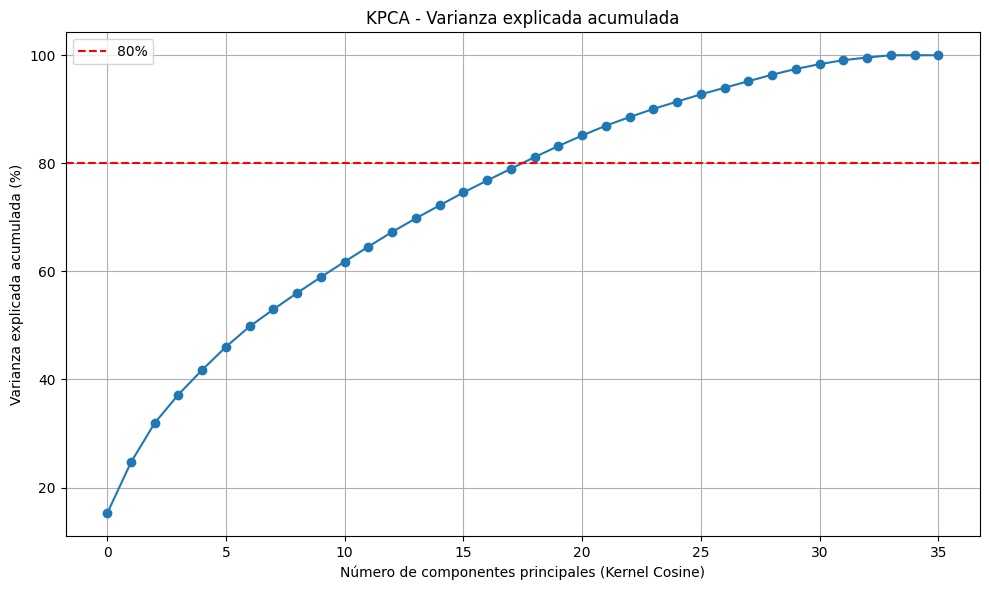


Componentes necesarias para explicar el 80% de la varianza (estimado): 19


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Liberar memoria
gc.collect()

#Cargar y preparar los datos
df = madrid_sale_train_df_expl.copy().astype(np.float32)  # Reducir precisión
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

#KernelPCA
n_components = 36
kpca = KernelPCA(
    n_components=n_components,
    kernel='cosine',
    eigen_solver='randomized',
    n_jobs=-1,
    fit_inverse_transform=False
)
X_kpca = kpca.fit_transform(df_scaled)

#Calcular varianza explicada (estimada)
component_variances = np.var(X_kpca, axis=0)
explained_variance_ratio_kpca = component_variances / np.sum(component_variances)
cumulative_variance_kpca = np.cumsum(explained_variance_ratio_kpca)

#Tabla de varianza explicada
df_varianza = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(n_components)],
    'Varianza Explicada (%)': explained_variance_ratio_kpca * 100,
    'Varianza Acumulada (%)': cumulative_variance_kpca * 100
})

print("\nVarianza explicada por cada componente principal (Kernel PCA - estimado):")
print(df_varianza.round(2))

#Gráfico
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_kpca * 100, marker='o')
plt.ylabel('Varianza explicada acumulada (%)')
plt.xlabel('Número de componentes principales (Kernel Cosine)')
plt.title('KPCA - Varianza explicada acumulada')
plt.grid(True)
plt.axhline(80, color='red', linestyle='--', label='80%')
plt.legend()
plt.tight_layout()
plt.show()

# Paso 6: Componentes necesarias para explicar el 80%
n_components_80 = np.argmax(cumulative_variance_kpca >= 0.80) + 1
print(f"\nComponentes necesarias para explicar el 80% de la varianza (estimado): {n_components_80}")



Una vez que se sabe que con 19 componentes principales es suficiente, se va a aplicar correctamente

In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
import seaborn as sns
import gc
# Liberar memoria
gc.collect()

# Paso 1: Cargar y preparar los datos de entrenamiento
train_df = madrid_sale_train_df_expl.copy().astype(np.float32)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_df)

# Paso 2: KernelPCA con solver aleatorizado
n_components = 19
kpca = KernelPCA(
    n_components=n_components,
    kernel='cosine',
    eigen_solver='randomized',
    n_jobs=-1,
    fit_inverse_transform=False
)
X_train_kpca = kpca.fit_transform(X_train_scaled)

In [35]:
#Guardamos para la aplicación
joblib.dump(kpca, "kpca.pkl")
# Guardar el scaler entrenado
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

Realizamos un análisis de correlación de las 2 primeras componentes principales (que son las que mas varianza explican) contra las variables originales, para ver cuales son las que tienen mas peso.

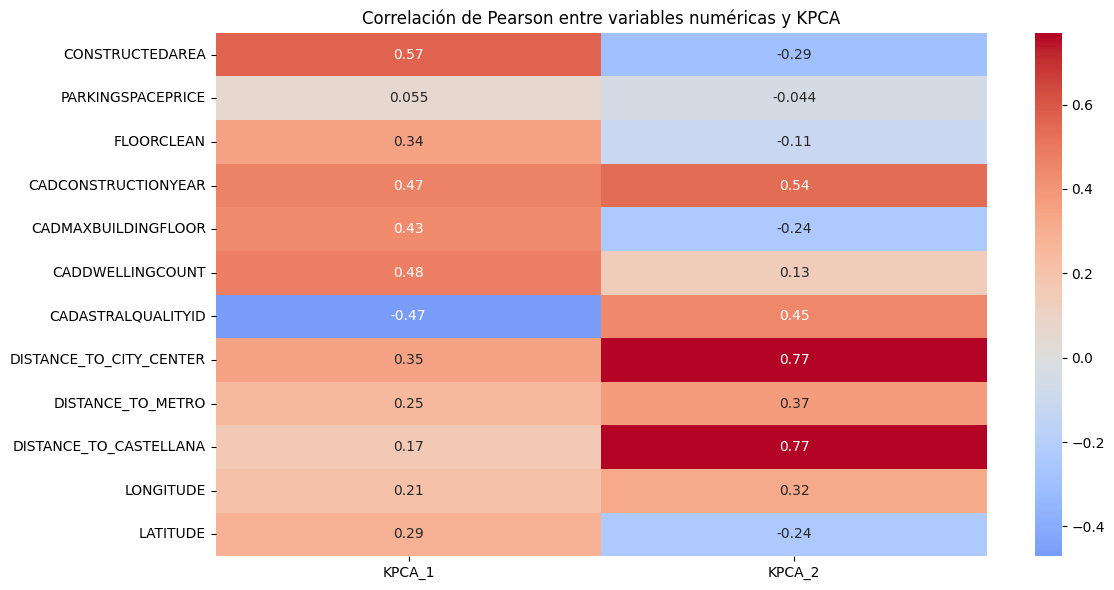

In [36]:
from scipy.stats import pearsonr, spearmanr, f_oneway

# Paso 1: KPCA con 2 componentes ya realizado -> df_kpca
df_kpca = pd.DataFrame(X_train_kpca[:, :2], columns=['KPCA_1', 'KPCA_2'])

# Paso 2: Unimos KPCA con las variables originales
df_full = pd.concat([df_kpca.reset_index(drop=True), madrid_sale_train_df_expl.reset_index(drop=True)], axis=1)

# Inicializamos resultados
correlaciones_pearson = {}
correlaciones_spearman = {}
anova_kpca1 = {}
anova_kpca2 = {}

excluded_cols = []  # Aquí puedes incluir variables a excluir si quieres
for col in madrid_sale_train_df_expl.columns:
    if col in excluded_cols:
        continue

    n_unique = madrid_sale_train_df_expl[col].nunique(dropna=True)

    # Variables numéricas (continuas)
    if n_unique > 10:
        try:
            valid_rows = df_full[['KPCA_1', 'KPCA_2', col]].dropna()
            corr_pearson_1, _ = pearsonr(valid_rows['KPCA_1'], valid_rows[col])
            corr_pearson_2, _ = pearsonr(valid_rows['KPCA_2'], valid_rows[col])
            correlaciones_pearson[col] = (corr_pearson_1, corr_pearson_2)

            corr_spear_1, _ = spearmanr(valid_rows['KPCA_1'], valid_rows[col])
            corr_spear_2, _ = spearmanr(valid_rows['KPCA_2'], valid_rows[col])
            correlaciones_spearman[col] = (corr_spear_1, corr_spear_2)
        except Exception as e:
            print(f"Error en correlación con {col}: {e}")

    # Variables categóricas (pocas categorías)
    elif n_unique <= 10:
        try:
            df_clean = df_full[[col, 'KPCA_1', 'KPCA_2']].dropna()
            groups_1 = [group['KPCA_1'] for _, group in df_clean.groupby(col)]
            groups_2 = [group['KPCA_2'] for _, group in df_clean.groupby(col)]

            if len(groups_1) > 1:
                anova_kpca1[col] = f_oneway(*groups_1).pvalue
            if len(groups_2) > 1:
                anova_kpca2[col] = f_oneway(*groups_2).pvalue
        except Exception as e:
            print(f"Error en ANOVA con {col}: {e}")

# Convertimos a DataFrame para visualizar
df_corrs = pd.DataFrame.from_dict(correlaciones_pearson, orient='index', columns=['KPCA_1', 'KPCA_2'])

plt.figure(figsize=(12, 6))
sns.heatmap(df_corrs, annot=True, cmap='coolwarm', center=0)
plt.title("Correlación de Pearson entre variables numéricas y KPCA")
plt.tight_layout()
plt.show()


## PCA al conjunto de test

In [37]:
#Cargar y preparar los datos de test
test_df = madrid_sale_test_df_expl.copy().astype(np.float32)

#Estandarización en test (usar el scaler ajustado en entrenamiento)
X_test_scaled = scaler.transform(test_df)

#Transformar el conjunto de test con KernelPCA
X_test_kpca = kpca.transform(X_test_scaled)



In [38]:
#Cambiar nombre a la variable respuesta
y_train_kpca=madrid_sale_train_df_obj
y_test_kpca=madrid_sale_test_df_obj
#Verificar dimensiones
print(f"Dimensiones del conjunto de entrenamiento transformado: {X_train_kpca.shape}")
print(f"Dimensiones de la variable respuesta de entrenamiento: {y_train_kpca.shape}")

print(f"Dimensiones del conjunto de test transformado: {X_test_kpca.shape}")
print(f"Dimensiones de la variable respuesta de test: {y_test_kpca.shape}")

Dimensiones del conjunto de entrenamiento transformado: (75851, 19)
Dimensiones de la variable respuesta de entrenamiento: (75851,)
Dimensiones del conjunto de test transformado: (18963, 19)
Dimensiones de la variable respuesta de test: (18963,)


# Realización del modelo

In [40]:
import pandas as pd
import numpy as np
# Cargar
X_train_kpca = np.load("X_train_kpca_wins.npy")
X_test_kpca = np.load("X_test_kpca_wins.npy")
y_train_kpca = np.load("y_train_kpca_wins.npy")
y_test_kpca = np.load("y_test_kpca_wins.npy")


## Regresión Lineal

In [41]:
import pandas as pd
import numpy as np
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

# Definir el modelo
modelo_lr = LinearRegression()

# Medir tiempo de entrenamiento
start_train = time.time()
modelo_lr.fit(X_train_kpca, y_train_kpca)
end_train = time.time()
train_time = end_train - start_train

# Medir tiempo de predicción en train
start_pred_train = time.time()
y_pred_train = modelo_lr.predict(X_train_kpca)
end_pred_train = time.time()
pred_time_train = end_pred_train - start_pred_train

# Medir tiempo de predicción en test
start_pred_test = time.time()
y_pred_test = modelo_lr.predict(X_test_kpca)
end_pred_test = time.time()
pred_time_test = end_pred_test - start_pred_test

# Función para métricas
def calcular_metricas(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    ratio_aceptable = np.mean(np.abs((y_true - y_pred) / y_true) < 0.10) * 100
    return r2, rmse, mae, mape, ratio_aceptable

# Calcular métricas
metrics_train = calcular_metricas(y_train_kpca, y_pred_train)
metrics_test = calcular_metricas(y_test_kpca, y_pred_test)

# Añadir tiempos a las métricas
metrics_train += (train_time + pred_time_train,)
metrics_test += (pred_time_test,)

# Crear tabla resumen con tiempos
df_metrics = pd.DataFrame(
    [metrics_train, metrics_test],
    index=["Entrenamiento", "Test"],
    columns=["R²", "RMSE", "MAE", "MAPE (%)", "Ratio aceptable (<10%)", "Tiempo (s)"]
)

# Mostrar resultados
print("\nMétricas de rendimiento y tiempos del modelo de regresión lineal:")
print(df_metrics.round(4))



Métricas de rendimiento y tiempos del modelo de regresión lineal:
                   R²         RMSE          MAE  MAPE (%)  \
Entrenamiento  0.6753  209514.5915  139000.7423   48.6434   
Test           0.6787  213016.8932  140512.6337   49.1098   

               Ratio aceptable (<10%)  Tiempo (s)  
Entrenamiento                 16.2239      0.0361  
Test                          16.1367      0.0008  


## Random forest

Para la realización del modelo Random Forest, se realizó una búsqueda exhaustiva de combinaciones de hiperparámetros clave con el fin de evaluar el impacto de cada uno en el desempeño predictivo. Las variables exploradas fueron las siguientes:
*	Número de árboles (n_estimators): Se probaron dos valores, 100 y 200 estimadores, para evaluar si aumentar la cantidad de árboles mejora la estabilidad y capacidad de generalización del modelo.
*	Profundidad máxima del árbol (max_depth): Se consideraron cuatro valores diferentes: None (sin límite), 5, 10 y 20. Esta variable controla la complejidad de cada árbol individual y tiene gran impacto en el balance entre sesgo y varianza, permitiendo observar cómo la profundidad afecta el sobreajuste.
*	Número mínimo de muestras para dividir un nodo (min_samples_split): Se exploraron los valores 2 y 5, para analizar cómo variar este umbral influye en la capacidad del modelo para generalizar evitando divisiones excesivamente específicas.
*	Número de características a considerar en cada división (max_features): Se probaron las opciones 'sqrt' y 'log2', dos estrategias comunes para seleccionar un subconjunto de variables en cada nodo, afectando la diversidad y correlación entre los árboles.


In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import product
import numpy as np
import pandas as pd

# Nuevo rango ampliado de hiperparámetros
param_grid = {
    'n_estimators':  [100, 200,300, 500],
    'max_depth': [None, 20, 30, 40],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

# Crear combinaciones de hiperparámetros
param_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['min_samples_split'],
    param_grid['max_features']
))

# Lista para guardar resultados
resultados_2 = []

# Iterar sobre combinaciones
for n_est, depth, min_split, max_feat in param_combinations:
    print(f"Evaluando: n_estimators={n_est}, max_depth={depth}, min_samples_split={min_split}, max_features={max_feat}")

    modelo_rf = RandomForestRegressor(
        n_estimators=n_est,
        max_depth=depth,
        min_samples_split=min_split,
        max_features=max_feat,
        random_state=42,
        n_jobs=-1
    )

    modelo_rf.fit(X_train_kpca, y_train_kpca)

    # Predicciones
    y_pred_train = modelo_rf.predict(X_train_kpca)
    y_pred_test = modelo_rf.predict(X_test_kpca)

    # Métricas para train y test
    r2_train, rmse_train, mae_train, mape_train, ratio_train = calcular_metricas(y_train_kpca, y_pred_train)
    r2_test, rmse_test, mae_test, mape_test, ratio_test = calcular_metricas(y_test_kpca, y_pred_test)

    resultados_2.append({
        'n_estimators': n_est,
        'max_depth': depth,
        'min_samples_split': min_split,
        'max_features': max_feat,
        'R2_Train': r2_train,
        'R2_Test': r2_test,
        'RMSE_Train': rmse_train,
        'RMSE_Test': rmse_test,
        'MAE_Train': mae_train,
        'MAE_Test': mae_test,
        'MAPE_Train (%)': mape_train,
        'MAPE_Test (%)': mape_test,
        'Ratio_Train (<10%)': ratio_train,
        'Ratio_Test (<10%)': ratio_test
    })

# Convertir a DataFrame
df_resultados_2 = pd.DataFrame(resultados_2)

Evaluando: n_estimators=100, max_depth=None, min_samples_split=2, max_features=sqrt
Evaluando: n_estimators=100, max_depth=None, min_samples_split=2, max_features=log2
Evaluando: n_estimators=100, max_depth=None, min_samples_split=5, max_features=sqrt
Evaluando: n_estimators=100, max_depth=None, min_samples_split=5, max_features=log2
Evaluando: n_estimators=100, max_depth=20, min_samples_split=2, max_features=sqrt
Evaluando: n_estimators=100, max_depth=20, min_samples_split=2, max_features=log2
Evaluando: n_estimators=100, max_depth=20, min_samples_split=5, max_features=sqrt
Evaluando: n_estimators=100, max_depth=20, min_samples_split=5, max_features=log2
Evaluando: n_estimators=100, max_depth=30, min_samples_split=2, max_features=sqrt
Evaluando: n_estimators=100, max_depth=30, min_samples_split=2, max_features=log2
Evaluando: n_estimators=100, max_depth=30, min_samples_split=5, max_features=sqrt
Evaluando: n_estimators=100, max_depth=30, min_samples_split=5, max_features=log2
Evaluand

In [44]:
#Imprimimos resultados
df_resultados_2.to_excel("resultados_random_forest_2_sin_outliers.xlsx", index=False)

Se va a realizar lo mismo, pero introduciendo el logaritmo de la variable objetivo

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import product
import numpy as np
import pandas as pd

# Transformamos target a logarítmica
y_train_log = np.log1p(y_train_kpca)
y_test_log = np.log1p(y_test_kpca)

# Definimos los valores a explorar
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

# Combinaciones de parámetros
param_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['min_samples_split'],
    param_grid['max_features']
))

# Lista para guardar resultados
resultados_3 = []

# Iterar sobre combinaciones
for n_est, depth, min_split, max_feat in param_combinations:
    print(f"Evaluando: n_estimators={n_est}, max_depth={depth}, min_samples_split={min_split}, max_features={max_feat}")

    modelo_rf = RandomForestRegressor(
        n_estimators=n_est,
        max_depth=depth,
        min_samples_split=min_split,
        max_features=max_feat,
        random_state=42,
        n_jobs=-1
    )

    # Entrenamiento con la variable target logarítmica
    modelo_rf.fit(X_train_kpca, y_train_log)

    # Predicciones en escala log
    y_pred_train_log = modelo_rf.predict(X_train_kpca)
    y_pred_test_log = modelo_rf.predict(X_test_kpca)

    # Volvemos a la escala original
    y_pred_train = np.expm1(y_pred_train_log)
    y_pred_test = np.expm1(y_pred_test_log)

    # Métricas usando valores reales en escala original
    r2_train, rmse_train, mae_train, mape_train, ratio_train = calcular_metricas(y_train_kpca, y_pred_train)
    r2_test, rmse_test, mae_test, mape_test, ratio_test = calcular_metricas(y_test_kpca, y_pred_test)

    resultados_3.append({
        'n_estimators': n_est,
        'max_depth': depth,
        'min_samples_split': min_split,
        'max_features': max_feat,
        'R2_Train': r2_train,
        'R2_Test': r2_test,
        'RMSE_Train': rmse_train,
        'RMSE_Test': rmse_test,
        'MAE_Train': mae_train,
        'MAE_Test': mae_test,
        'MAPE_Train (%)': mape_train,
        'MAPE_Test (%)': mape_test,
        'Ratio_Train (<10%)': ratio_train,
        'Ratio_Test (<10%)': ratio_test
    })

# Convertir a DataFrame
df_resultados_3 = pd.DataFrame(resultados_3)

Evaluando: n_estimators=100, max_depth=None, min_samples_split=2, max_features=sqrt
Evaluando: n_estimators=100, max_depth=None, min_samples_split=2, max_features=log2
Evaluando: n_estimators=100, max_depth=None, min_samples_split=5, max_features=sqrt
Evaluando: n_estimators=100, max_depth=None, min_samples_split=5, max_features=log2
Evaluando: n_estimators=100, max_depth=5, min_samples_split=2, max_features=sqrt
Evaluando: n_estimators=100, max_depth=5, min_samples_split=2, max_features=log2
Evaluando: n_estimators=100, max_depth=5, min_samples_split=5, max_features=sqrt
Evaluando: n_estimators=100, max_depth=5, min_samples_split=5, max_features=log2
Evaluando: n_estimators=100, max_depth=10, min_samples_split=2, max_features=sqrt
Evaluando: n_estimators=100, max_depth=10, min_samples_split=2, max_features=log2
Evaluando: n_estimators=100, max_depth=10, min_samples_split=5, max_features=sqrt
Evaluando: n_estimators=100, max_depth=10, min_samples_split=5, max_features=log2
Evaluando: n

In [46]:
#Imprimimos resultados
df_resultados_3.to_excel("resultados_random_forest_3_sin_outliers.xlsx", index=False)

Modelo final

In [51]:
import pandas as pd
import numpy as np
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

# Aplicar logaritmo a la variable objetivo de entrenamiento
y_train_kpca_log = np.log(y_train_kpca)

# Inicializar el modelo
modelo_final_rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# Entrenamiento
start_train = time.time()
modelo_final_rf.fit(X_train_kpca, y_train_kpca_log)
end_train = time.time()
train_time = end_train - start_train
print(f"Tiempo de entrenamiento: {train_time:.2f} segundos")

# Predicción (en log)
start_pred = time.time()
y_pred_log = modelo_final_rf.predict(X_test_kpca)
end_pred = time.time()
pred_time = end_pred - start_pred
print(f"Tiempo de predicción: {pred_time:.4f} segundos")

Tiempo de entrenamiento: 13.22 segundos
Tiempo de predicción: 0.1981 segundos


## XGBoost

In [47]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import product
import numpy as np
import pandas as pd

# Definir la malla de hiperparámetros a explorar
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 2, 5, 10, 20, 40, 60],
    'learning_rate': [0.1, 0.2, 0.5, 1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Generar combinaciones de parámetros
param_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['learning_rate'],
    param_grid['subsample'],
    param_grid['colsample_bytree']
))

# Lista para guardar resultados
resultados = []


# Iterar sobre todas las combinaciones
for n_est, depth, lr, subs, colsample in param_combinations:
    print(f"Evaluando: n_estimators={n_est}, max_depth={depth}, learning_rate={lr}, subsample={subs}, colsample_bytree={colsample}")

    modelo_xgb = XGBRegressor(
        n_estimators=n_est,
        max_depth=depth,
        learning_rate=lr,
        subsample=subs,
        colsample_bytree=colsample,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

    modelo_xgb.fit(X_train_kpca, y_train_kpca)

    # Predicciones
    y_pred_train = modelo_xgb.predict(X_train_kpca)
    y_pred_test = modelo_xgb.predict(X_test_kpca)

    # Calcular métricas
    r2_train, rmse_train, mae_train, mape_train, ratio_train = calcular_metricas(y_train_kpca, y_pred_train)
    r2_test, rmse_test, mae_test, mape_test, ratio_test = calcular_metricas(y_test_kpca, y_pred_test)

    resultados.append({
        'n_estimators': n_est,
        'max_depth': depth,
        'learning_rate': lr,
        'subsample': subs,
        'colsample_bytree': colsample,
        'R2_Train': r2_train,
        'R2_Test': r2_test,

        'RMSE_Train': rmse_train,
        'RMSE_Test': rmse_test,
        'MAE_Train': mae_train,
        'MAE_Test': mae_test,
        'MAPE_Train (%)': mape_train,
        'MAPE_Test (%)': mape_test,
        'Ratio_Train (<10%)': ratio_train,
        'Ratio_Test (<10%)': ratio_test
    })

# Convertir a DataFrame y ordenar
df_resultados_xgb = pd.DataFrame(resultados)
df_resultados_xgb_ordenado = df_resultados_xgb.sort_values(by='R2_Test', ascending=False)

# Mostrar top 5 mejores configuraciones
print(df_resultados_xgb_ordenado.round(2).head())


Evaluando: n_estimators=100, max_depth=None, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8
Evaluando: n_estimators=100, max_depth=None, learning_rate=0.1, subsample=0.8, colsample_bytree=1
Evaluando: n_estimators=100, max_depth=None, learning_rate=0.1, subsample=1, colsample_bytree=0.8
Evaluando: n_estimators=100, max_depth=None, learning_rate=0.1, subsample=1, colsample_bytree=1
Evaluando: n_estimators=100, max_depth=None, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8
Evaluando: n_estimators=100, max_depth=None, learning_rate=0.2, subsample=0.8, colsample_bytree=1
Evaluando: n_estimators=100, max_depth=None, learning_rate=0.2, subsample=1, colsample_bytree=0.8
Evaluando: n_estimators=100, max_depth=None, learning_rate=0.2, subsample=1, colsample_bytree=1
Evaluando: n_estimators=100, max_depth=None, learning_rate=0.5, subsample=0.8, colsample_bytree=0.8
Evaluando: n_estimators=100, max_depth=None, learning_rate=0.5, subsample=0.8, colsample_bytree=1
Evaluando: n_estim

In [48]:
df_resultados_xgb.to_excel("resultados_XGB_sin_outliers.xlsx", index=False)

Ahora se prueba con la variable objetivo logaritmica

In [49]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import product
import numpy as np
import pandas as pd

# Definir la malla de hiperparámetros a explorar
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20, 40, 60],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [1]
}

# Generar combinaciones de parámetros
param_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['learning_rate'],
    param_grid['subsample'],
    param_grid['colsample_bytree']
))

# Lista para guardar resultados
resultados_3 = []

# Aplicar transformación logarítmica a la variable objetivo
y_train_log = np.log(y_train_kpca)
y_test_log = np.log(y_test_kpca)

# Función de métricas adaptada para predicciones log-transformadas
def calcular_metricas_log(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    ratio_aceptable = np.mean(np.abs((y_true - y_pred) / y_true) < 0.10) * 100
    return r2, rmse, mae, mape, ratio_aceptable

# Iterar sobre todas las combinaciones
for n_est, depth, lr, subs, colsample in param_combinations:
    print(f"Evaluando: n_estimators={n_est}, max_depth={depth}, learning_rate={lr}, subsample={subs}, colsample_bytree={colsample}")

    modelo_xgb = XGBRegressor(
        n_estimators=n_est,
        max_depth=depth,
        learning_rate=lr,
        subsample=subs,
        colsample_bytree=colsample,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

    modelo_xgb.fit(X_train_kpca, y_train_log)

    # Predicciones en escala log
    y_pred_train_log = modelo_xgb.predict(X_train_kpca)
    y_pred_test_log = modelo_xgb.predict(X_test_kpca)

    # Calcular métricas destransformando a escala original
    r2_train, rmse_train, mae_train, mape_train, ratio_train = calcular_metricas_log(y_train_log, y_pred_train_log)
    r2_test, rmse_test, mae_test, mape_test, ratio_test = calcular_metricas_log(y_test_log, y_pred_test_log)

    resultados_3.append({
        'n_estimators': n_est,
        'max_depth': depth,
        'learning_rate': lr,
        'subsample': subs,
        'colsample_bytree': colsample,
        'R2_Train': r2_train,
        'R2_Test': r2_test,
        'RMSE_Train': rmse_train,
        'RMSE_Test': rmse_test,
        'MAE_Train': mae_train,
        'MAE_Test': mae_test,
        'MAPE_Train (%)': mape_train,
        'MAPE_Test (%)': mape_test,
        'Ratio_Train (<10%)': ratio_train,
        'Ratio_Test (<10%)': ratio_test
    })

# Convertir a DataFrame y ordenar
df_resultados_3_xgb = pd.DataFrame(resultados_3)

Evaluando: n_estimators=100, max_depth=20, learning_rate=0.1, subsample=0.8, colsample_bytree=1
Evaluando: n_estimators=100, max_depth=40, learning_rate=0.1, subsample=0.8, colsample_bytree=1
Evaluando: n_estimators=100, max_depth=60, learning_rate=0.1, subsample=0.8, colsample_bytree=1
Evaluando: n_estimators=200, max_depth=20, learning_rate=0.1, subsample=0.8, colsample_bytree=1
Evaluando: n_estimators=200, max_depth=40, learning_rate=0.1, subsample=0.8, colsample_bytree=1
Evaluando: n_estimators=200, max_depth=60, learning_rate=0.1, subsample=0.8, colsample_bytree=1


In [50]:
df_resultados_3_xgb.to_excel("resultados_XGB_3_sin_outliers.xlsx", index=False)

Modelo definitivo:

In [53]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import time

# Aplicar transformación logarítmica a la variable objetivo
y_train_log = np.log(y_train_kpca)
y_test_log = np.log(y_test_kpca)

# Función de métricas adaptada para predicciones log-transformadas
def calcular_metricas_log(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    ratio_aceptable = np.mean(np.abs((y_true - y_pred) / y_true) < 0.10) * 100
    return r2, rmse, mae, mape, ratio_aceptable

# Inicializar el modelo con los hiperparámetros indicados
modelo_xgb = XGBRegressor(
    n_estimators=200,
    max_depth=20,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=1,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Tiempo de entrenamiento
start_train = time.time()
modelo_xgb.fit(X_train_kpca, y_train_log)
end_train = time.time()
train_time = end_train - start_train

# Tiempo de predicción
start_pred = time.time()
y_pred_test_log = modelo_xgb.predict(X_test_kpca)
end_pred = time.time()
pred_time = end_pred - start_pred

# Calcular métricas en escala original
r2_test, rmse_test, mae_test, mape_test, ratio_test = calcular_metricas_log(y_test_log, y_pred_test_log)

# Mostrar resultados
print(f"Tiempo de entrenamiento: {train_time:.2f} segundos")
print(f"Tiempo de predicción: {pred_time:.4f} segundos")

Tiempo de entrenamiento: 61.77 segundos
Tiempo de predicción: 0.1343 segundos


Guardamos el modelo para la aplicación

In [84]:
# Guardar el modelo XGBoost
joblib.dump(modelo_xgb, "modelo_xgb.pkl")

['modelo_xgb.pkl']

## Red Neuronal Densa

In [54]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import time

# Escalar los datos (muy importante para redes neuronales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_kpca)
X_test_scaled = scaler.transform(X_test_kpca)

# Crear modelo
modelo_dnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(32, activation='relu'),

    Dense(1)  # Salida de regresión
])

# Compilar el modelo
modelo_dnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

# Early stopping para val_mae con paciencia de 4 épocas
early_stop = EarlyStopping(monitor='val_mae', patience=4, restore_best_weights=True)

# Entrenar
start_train = time.time()
historial = modelo_dnn.fit(
    X_train_scaled,
    y_train_kpca,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)
end_train = time.time()

# Tiempo de entrenamiento
tiempo_entrenamiento = end_train - start_train

# Predicción
start_pred = time.time()
y_pred_dnn = modelo_dnn.predict(X_test_scaled).flatten()
end_pred = time.time()

tiempo_prediccion = end_pred - start_pred


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 173156368384.0000 - mae: 283444.8750 - val_loss: 38953496576.0000 - val_mae: 129567.2188
Epoch 2/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 44067250176.0000 - mae: 138264.7656 - val_loss: 27131428864.0000 - val_mae: 101062.7891
Epoch 3/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 36097212416.0000 - mae: 117885.5547 - val_loss: 24419753984.0000 - val_mae: 93300.7969
Epoch 4/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 33461071872.0000 - mae: 112231.0859 - val_loss: 24055439360.0000 - val_mae: 90841.4375
Epoch 5/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 31599558656.0000 - mae: 109673.2188 - val_loss: 23168759808.0000 - val_mae: 90122.2969
Epoch 6/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 31801141248.0000 - mae: 110690.5781 - val_loss: 23074054144.0000 - val_mae: 88141.2109
Epoch 7/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 31335399424.0000 - mae: 109463.88

In [55]:
# Evaluar
r2, rmse, mae, mape, ratio = calcular_metricas(y_test_kpca, y_pred_dnn)

# Mostrar resultados
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE: {mae:,.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Ratio aceptable (<10%): {ratio:.2f}%")
print(f"Tiempo entrenamiento: {tiempo_entrenamiento:.2f}s")
print(f"Tiempo predicción: {tiempo_prediccion:.2f}s")


R²: 0.838
RMSE: 151,248.04
MAE: 85,844.68
MAPE: 23.14%
Ratio aceptable (<10%): 29.49%
Tiempo entrenamiento: 115.21s
Tiempo predicción: 1.81s


In [56]:
def evaluar_modelo(y_true, y_pred, nombre_modelo="Modelo"):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"\nResultados - {nombre_modelo}")
    print(f"R2 Score:         {r2:.4f}")
    print(f"MAE:              {mae:.2f}")
    print(f"RMSE:             {rmse:.2f}")
    print(f"MAPE (%):         {mape:.2f}")


Probamos transformaciones. Primero transformamos variable target

In [57]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_kpca)
X_test_scaled = scaler.transform(X_test_kpca)

# Transformación logarítmica
y_train_log = np.log1p(y_train_kpca)
y_test_log = np.log1p(y_test_kpca)

# Modelo
modelo_dnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

modelo_dnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

historial = modelo_dnn.fit(
    X_train_scaled,
    y_train_log,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Predicción y deslog
y_pred_dnn_log = np.expm1(modelo_dnn.predict(X_test_scaled).flatten())


Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1897/1897 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 19.8919 - mae: 2.9650 - val_loss: 1.4537 - val_mae: 1.1015
Epoch 2/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.5006 - mae: 0.9643 - val_loss: 0.4322 - val_mae: 0.5829
Epoch 3/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2665 - mae: 0.4032 - val_loss: 0.1069 - val_mae: 0.2566
Epoch 4/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1601 - mae: 0.3099 - val_loss: 0.0915 - val_mae: 0.2352
Epoch 5/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1373 - mae: 0.2885 - val_loss: 0.0843 - val_mae: 0.2256
Epoch 6/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1246 - mae: 0.2754 - val_loss: 0.0920 - val_mae: 0.2362
Epoch 7/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1131 - mae: 0.2609 - val_loss: 0.0806 - val_mae: 0.2198
Epoch 8/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1037 - mae: 0.2500 - val_loss: 0.0824 - val_mae: 0.2220
Epoch 9/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 

In [58]:
evaluar_modelo(y_test_kpca, y_pred_dnn_log, "DNN Básico")



Resultados - DNN Básico
R2 Score:         0.8412
MAE:              85587.59
RMSE:             149771.18
MAPE (%):         24.41


Segundo, se hace la red mas profunda

In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import time

# Escalar los datos (muy importante para redes neuronales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_kpca)
X_test_scaled = scaler.transform(X_test_kpca)

# Crear modelo
modelo_dnn = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])


# Compilar el modelo
modelo_dnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

# Early stopping para val_mae con paciencia de 6 épocas
early_stop = EarlyStopping(monitor='val_mae', patience=6, restore_best_weights=True)

# Entrenar
start_train = time.time()
historial = modelo_dnn.fit(
    X_train_scaled,
    y_train_kpca,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)
end_train = time.time()

# Tiempo de entrenamiento
tiempo_entrenamiento = end_train - start_train

# Predicción
start_pred = time.time()
y_pred_dnn_profundo = modelo_dnn.predict(X_test_scaled).flatten()
end_pred = time.time()

tiempo_prediccion = end_pred - start_pred


Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1897/1897 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 266977656832.0000 - mae: 373636.2500 - val_loss: 90568261632.0000 - val_mae: 209390.6875
Epoch 2/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 64481587200.0000 - mae: 162520.4219 - val_loss: 24962744320.0000 - val_mae: 99538.6875
Epoch 3/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 37161205760.0000 - mae: 123346.3359 - val_loss: 23679895552.0000 - val_mae: 94474.5469
Epoch 4/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 34090078208.0000 - mae: 116321.1016 - val_loss: 22754349056.0000 - val_mae: 88531.5859
Epoch 5/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 34204950528.0000 - mae: 114576.3906 - val_loss: 22013618176.0000 - val_mae: 86406.8594
Epoch 6/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 32321214464.0000 - mae: 111510.5781 - val_loss: 21364963328.0000 - val_mae: 84056.8984
Epoch 7/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 31484346368.0000 - mae: 111199.6172 - val_loss

In [60]:
evaluar_modelo(y_test_kpca, y_pred_dnn_profundo, "DNN Profundo")



Resultados - DNN Profundo
R2 Score:         0.8628
MAE:              78333.90
RMSE:             139211.94
MAPE (%):         21.02


Cambiamos transformador

In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import time
from tensorflow.keras.optimizers import RMSprop


# Escalar los datos (muy importante para redes neuronales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_kpca)
X_test_scaled = scaler.transform(X_test_kpca)

# Crear modelo
modelo_dnn = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])


# Compilar el modelo
modelo_dnn.compile(
    optimizer=RMSprop(learning_rate=0.0005),
    loss='mean_squared_error',
    metrics=['mae']
)

# Early stopping para val_mae con paciencia de 4 épocas
early_stop = EarlyStopping(monitor='val_mae', patience=4, restore_best_weights=True)

# Entrenar
start_train = time.time()
historial = modelo_dnn.fit(
    X_train_scaled,
    y_train_kpca,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)
end_train = time.time()

# Tiempo de entrenamiento
tiempo_entrenamiento = end_train - start_train

# Predicción
start_pred = time.time()
y_pred_dnn_rmsprop = modelo_dnn.predict(X_test_scaled).flatten()
end_pred = time.time()

tiempo_prediccion = end_pred - start_pred


Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1897/1897 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 293471191040.0000 - mae: 392200.8125 - val_loss: 278801907712.0000 - val_mae: 382572.9062
Epoch 2/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 266138058752.0000 - mae: 375273.0000 - val_loss: 233488367616.0000 - val_mae: 350439.6562
Epoch 3/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 210656624640.0000 - mae: 330759.8438 - val_loss: 142542094336.0000 - val_mae: 270314.1875
Epoch 4/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 118270050304.0000 - mae: 234057.4219 - val_loss: 48247472128.0000 - val_mae: 138811.6250
Epoch 5/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 47956942848.0000 - mae: 135619.4844 - val_loss: 24605270016.0000 - val_mae: 97049.2344
Epoch 6/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 36114247680.0000 - mae: 122410.4688 - val_loss: 23725639680.0000 - val_mae: 94480.7578
Epoch 7/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 36775800832.0000 - mae: 121158.9375 -

In [62]:
evaluar_modelo(y_test_kpca, y_pred_dnn_rmsprop, "DNN con RMSprop")


Resultados - DNN con RMSprop
R2 Score:         0.8616
MAE:              78684.49
RMSE:             139804.59
MAPE (%):         21.35


Todo lo anterior junto

In [63]:
import numpy as np
import tensorflow as tf
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_kpca)
X_test_scaled = scaler.transform(X_test_kpca)

# Transformación logarítmica
y_train_log = np.log1p(y_train_kpca)
y_test_log = np.log1p(y_test_kpca)

# Modelo profundo + regularización
modelo_dnn = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compilar con RMSprop
modelo_dnn.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005),
    loss='mean_squared_error',
    metrics=['mae']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Tiempo de entrenamiento
start_train = time.time()
historial = modelo_dnn.fit(
    X_train_scaled,
    y_train_log,
    validation_split=0.2,
    epochs=300,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
end_train = time.time()
train_time = end_train - start_train

# Tiempo de predicción
start_pred = time.time()
y_pred_log = modelo_dnn.predict(X_test_scaled).flatten()
end_pred = time.time()
pred_time = end_pred - start_pred

# Deslogaritmizar
y_pred = np.expm1(y_pred_log)
y_true = y_test_kpca

# Evaluación
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
ratio_10 = np.mean(np.abs((y_true - y_pred) / y_true) < 0.10) * 100

# Mostrar resultados
print(f"\n📊 Resultados del modelo DNN (con log transform):")
print(f"🕒 Tiempo de entrenamiento: {train_time:.2f} segundos")
print(f"🕒 Tiempo de predicción: {pred_time:.4f} segundos")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE: {mae:,.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Ratio de errores <10%: {ratio_10:.2f}%")


Epoch 1/300


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


949/949 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 36.4231 - mae: 4.5909 - val_loss: 0.4150 - val_mae: 0.5143 - learning_rate: 5.0000e-04
Epoch 2/300
949/949 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.0892 - mae: 1.4001 - val_loss: 0.5220 - val_mae: 0.5991 - learning_rate: 5.0000e-04
Epoch 3/300
949/949 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.1614 - mae: 1.1709 - val_loss: 0.4350 - val_mae: 0.5361 - learning_rate: 5.0000e-04
Epoch 4/300
949/949 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.6872 - mae: 1.0309 - val_loss: 0.5032 - val_mae: 0.6099 - learning_rate: 5.0000e-04
Epoch 5/300
949/949 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.3913 - mae: 0.9390 - val_loss: 0.3418 - val_mae: 0.4713 - learning_rate: 5.0000e-04
Epoch 6/300
949/949 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.2074 - mae: 0.8755 - val_loss: 0.4407 - val_mae: 0.5720 - learning_rate: 5.0000e-04
Epoch 7/300
949/949 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.0289 - mae: 0.8045 - val_loss: 0.1742 - val_mae: 0.3344 - learning

## Modelo transformer

In [71]:
import torch
import torch.nn as nn
import math
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error

# === Positional Encoding ===
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# === Modelo Transformer ===
class EnhancedTransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=8, num_layers=4, dim_feedforward=256, dropout=0.2):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, activation='gelu', batch_first=True, norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.regressor = nn.Sequential(
            nn.LayerNorm(d_model * input_dim),
            nn.Linear(d_model * input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = x.unsqueeze(-1)
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = x.flatten(start_dim=1)
        return self.regressor(x)

# === Escalado ===
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_kpca.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test_kpca.reshape(-1, 1))

# === DataLoader ===
train_dataset = TensorDataset(
    torch.tensor(X_train_kpca, dtype=torch.float32),
    torch.tensor(y_train_scaled, dtype=torch.float32)
)
test_dataset = TensorDataset(
    torch.tensor(X_test_kpca, dtype=torch.float32),
    torch.tensor(y_test_scaled, dtype=torch.float32)
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# === Entrenamiento con EarlyStopping ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedTransformerRegressor(input_dim=X_train_kpca.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# --- Early stopping manual ---
patience = 4
best_mae = float('inf')
epochs_no_improve = 0
best_model_state = None
num_epochs = 100

def get_preds(loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy()
            preds.append(pred)
            trues.append(yb.numpy())
    return np.vstack(preds).flatten(), np.vstack(trues).flatten()

start_train = time.time()
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_train_loss = total_loss / len(train_loader.dataset)

    # === Evaluar en test para MAE ===
    val_preds_scaled, val_true_scaled = get_preds(test_loader)
    val_mae = mean_absolute_error(val_true_scaled, val_preds_scaled)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val MAE: {val_mae:.4f}")

    if val_mae < best_mae:
        best_mae = val_mae
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\n🛑 Early stopping: no mejora en {patience} épocas consecutivas.")
            break

# Restaurar mejores pesos
if best_model_state:
    model.load_state_dict(best_model_state)

end_train = time.time()
print(f"\n⏱️ Tiempo total de entrenamiento: {end_train - start_train:.2f} segundos")

# === Predicción y desescalado ===
# === Tiempo de predicción en test ===
train_preds_scaled, train_true_scaled = get_preds(train_loader)
start_test = time.time()
test_preds_scaled, test_true_scaled = get_preds(test_loader)
end_test = time.time()
print(f"\n⏱️ Tiempo de predicción en test: {end_test - start_test:.4f} segundos")

train_preds = scaler_y.inverse_transform(train_preds_scaled.reshape(-1, 1)).flatten()
train_true = scaler_y.inverse_transform(train_true_scaled.reshape(-1, 1)).flatten()
test_preds = scaler_y.inverse_transform(test_preds_scaled.reshape(-1, 1)).flatten()
test_true = scaler_y.inverse_transform(test_true_scaled.reshape(-1, 1)).flatten()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 1/100 | Train Loss: 0.2385 | Val MAE: 0.2530
Epoch 2/100 | Train Loss: 0.1853 | Val MAE: 0.2358
Epoch 3/100 | Train Loss: 0.1799 | Val MAE: 0.2293
Epoch 4/100 | Train Loss: 0.1740 | Val MAE: 0.2263
Epoch 5/100 | Train Loss: 0.1694 | Val MAE: 0.2309
Epoch 6/100 | Train Loss: 0.1655 | Val MAE: 0.2325
Epoch 7/100 | Train Loss: 0.1644 | Val MAE: 0.2517
Epoch 8/100 | Train Loss: 0.1616 | Val MAE: 0.2300

🛑 Early stopping: no mejora en 4 épocas consecutivas.

⏱️ Tiempo total de entrenamiento: 124.76 segundos

⏱️ Tiempo de predicción en test: 0.7558 segundos


In [72]:
# Métricas
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def ratio_under_10(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / y_true < 0.10) * 100

print("\nTrain metrics:")
print(f"R2: {r2_score(train_true, train_preds):.4f}")
print(f"RMSE: {mean_squared_error(train_true, train_preds):.2f}")
print(f"MAE: {mean_absolute_error(train_true, train_preds):.2f}")
print(f"MAPE (%): {mape(train_true, train_preds):.2f}")
print(f"Ratio (<10% error) (%): {ratio_under_10(train_true, train_preds):.2f}")

print("\nTest metrics:")
print(f"R2: {r2_score(test_true, test_preds):.4f}")
print(f"RMSE: {mean_squared_error(test_true, test_preds):.2f}")
print(f"MAE: {mean_absolute_error(test_true, test_preds):.2f}")
print(f"MAPE (%): {mape(test_true, test_preds):.2f}")
print(f"Ratio (<10% error) (%): {ratio_under_10(test_true, test_preds):.2f}")

print("\nPrimeros 5 valores predichos vs reales (test):")
for pred, real in zip(test_preds[:5], test_true[:5]):
    print(f"Predicho: {pred:.2f}, Real: {real:.2f}")



Train metrics:
R2: 0.8518
RMSE: 20031991808.00
MAE: 82395.27
MAPE (%): 22.08
Ratio (<10% error) (%): 29.73

Test metrics:
R2: 0.8472
RMSE: 21572427776.00
MAE: 84561.77
MAPE (%): 22.37
Ratio (<10% error) (%): 29.78

Primeros 5 valores predichos vs reales (test):
Predicho: 106914.41, Real: 105000.01
Predicho: 422690.03, Real: 399000.00
Predicho: 1351990.12, Real: 777000.00
Predicho: 105097.26, Real: 135000.00
Predicho: 216497.44, Real: 319000.00


In [70]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Dataset personalizado
class PCADataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Modelo Transformer simple
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.embedding = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Sequential(
            nn.Linear(d_model * input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = x.unsqueeze(-1)
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)
        x = x.flatten(start_dim=1)
        return self.regressor(x)

# Escalado del target
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_kpca.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test_kpca.reshape(-1, 1))

# Dataset y dataloaders
full_train_dataset = PCADataset(X_train_kpca, pd.Series(y_train_scaled.flatten()))
val_size = int(0.2 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

test_dataset = PCADataset(X_test_kpca, pd.Series(y_test_scaled.flatten()))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# Entrenamiento con early stopping
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerRegressor(input_dim=X_train_kpca.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_val_loss = float('inf')
patience = 4
counter = 0
num_epochs = 100

start_train = time.time()
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_train_loss = total_loss / len(train_loader.dataset)

    # Validación
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_loss += criterion(preds, yb).item() * xb.size(0)
    avg_val_loss = val_loss / len(val_loader.dataset)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"🛑 Early stopping triggered at epoch {epoch+1}")
            break

end_train = time.time()
print(f"\n⏱️ Tiempo total de entrenamiento: {end_train - start_train:.2f} segundos")

# === Carga del mejor modelo ===
model.load_state_dict(torch.load('best_model.pt'))

# === Predicciones ===
def get_preds(loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy()
            preds.append(pred)
            trues.append(yb.numpy())
    return np.vstack(preds).flatten(), np.vstack(trues).flatten()


# === TEST CON TIEMPO ===
start_test = time.time()
train_preds_scaled, train_true_scaled = get_preds(train_loader)
test_preds_scaled, test_true_scaled = get_preds(test_loader)
end_test = time.time()
test_time = end_test - start_test
print(f"\n⏱️ Tiempo de predicción en test: {test_time:.4f} segundos")


# Desescalado
train_preds = scaler_y.inverse_transform(train_preds_scaled.reshape(-1, 1)).flatten()
train_true = scaler_y.inverse_transform(train_true_scaled.reshape(-1, 1)).flatten()
test_preds = scaler_y.inverse_transform(test_preds_scaled.reshape(-1, 1)).flatten()
test_true = scaler_y.inverse_transform(test_true_scaled.reshape(-1, 1)).flatten()

# Métricas
def mape(y_true, y_pred): return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def ratio_under_10(y_true, y_pred): return np.mean(np.abs(y_true - y_pred) / y_true < 0.10) * 100

print("\nTrain metrics:")
print(f"R2: {r2_score(train_true, train_preds):.4f}")
print(f"RMSE: {mean_squared_error(train_true, train_preds):.2f}")
print(f"MAE: {mean_absolute_error(train_true, train_preds):.2f}")
print(f"MAPE (%): {mape(train_true, train_preds):.2f}")
print(f"Ratio (<10% error): {ratio_under_10(train_true, train_preds):.2f}%")

print("\nTest metrics:")
print(f"R2: {r2_score(test_true, test_preds):.4f}")
print(f"RMSE: {mean_squared_error(test_true, test_preds):.2f}")
print(f"MAE: {mean_absolute_error(test_true, test_preds):.2f}")
print(f"MAPE (%): {mape(test_true, test_preds):.2f}")
print(f"Ratio (<10% error): {ratio_under_10(test_true, test_preds):.2f}%")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Train Loss: 0.2635, Val Loss: 0.2088
Epoch 2, Train Loss: 0.1891, Val Loss: 0.1810
Epoch 3, Train Loss: 0.1770, Val Loss: 0.1655
Epoch 4, Train Loss: 0.1743, Val Loss: 0.1583
Epoch 5, Train Loss: 0.1665, Val Loss: 0.1518
Epoch 6, Train Loss: 0.1635, Val Loss: 0.1553
Epoch 7, Train Loss: 0.1605, Val Loss: 0.1603
Epoch 8, Train Loss: 0.1552, Val Loss: 0.1502
Epoch 9, Train Loss: 0.1532, Val Loss: 0.1717
Epoch 10, Train Loss: 0.1518, Val Loss: 0.1454
Epoch 11, Train Loss: 0.1480, Val Loss: 0.1414
Epoch 12, Train Loss: 0.1455, Val Loss: 0.1445
Epoch 13, Train Loss: 0.1444, Val Loss: 0.1503
Epoch 14, Train Loss: 0.1423, Val Loss: 0.1406
Epoch 15, Train Loss: 0.1398, Val Loss: 0.1388
Epoch 16, Train Loss: 0.1386, Val Loss: 0.1376
Epoch 17, Train Loss: 0.1351, Val Loss: 0.1435
Epoch 18, Train Loss: 0.1350, Val Loss: 0.1531
Epoch 19, Train Loss: 0.1322, Val Loss: 0.1386
Epoch 20, Train Loss: 0.1295, Val Loss: 0.1550
🛑 Early stopping triggered at epoch 20

⏱️ Tiempo total de entrenamie

# Desarrollo de Interfaz

In [73]:
!pip install streamlit pyngrok xgboost joblib

In [79]:
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
import joblib
from xgboost import XGBRegressor

# === Cargar artefactos del pipeline entrenado ===
scaler = joblib.load("scaler.pkl")
kpca = joblib.load("kpca.pkl")
xgb_model = joblib.load("modelo_xgb.pkl")

# Cargar los percentiles de outliers (ajustados previamente sobre madrid_sale_train_df)
q_low = joblib.load("percentil_01.pkl")   # Series con el percentil 0.01 por variable
q_high = joblib.load("percentil_99.pkl")  # Series con el percentil 0.99 por variable

# Lista de características en orden correcto
features = [
    'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER', 'HASTERRACE', 'HASLIFT',
    'HASAIRCONDITIONING', 'AMENITYID', 'HASPARKINGSPACE',
    'ISPARKINGSPACEINCLUDEDINPRICE', 'PARKINGSPACEPRICE',
    'HASNORTHORIENTATION', 'HASSOUTHORIENTATION', 'HASEASTORIENTATION',
    'HASWESTORIENTATION', 'HASBOXROOM', 'HASWARDROBE', 'HASSWIMMINGPOOL',
    'HASDOORMAN', 'HASGARDEN', 'ISDUPLEX', 'ISSTUDIO', 'ISINTOPFLOOR',
    'FLOORCLEAN', 'FLATLOCATIONID', 'CADCONSTRUCTIONYEAR',
    'CADMAXBUILDINGFLOOR', 'CADDWELLINGCOUNT', 'CADASTRALQUALITYID',
    'BUILTTYPEID_1', 'BUILTTYPEID_2', 'BUILTTYPEID_3',
    'DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO',
    'DISTANCE_TO_CASTELLANA', 'LONGITUDE', 'LATITUDE'
]



# === Función para tratar outliers ===
def tratar_outliers(df, q_low, q_high):
    df_clipped = df.copy()
    for col in df.columns:
        df_clipped[col] = np.clip(df[col], q_low[col], q_high[col])
    return df_clipped

# === Interfaz ===
st.title("🧠 Real estate price forecasting (Madrid)")
st.write("Enter the data of the property to estimate its price:")

user_input = {}
for col in features:
    if col.startswith('HAS') or col.startswith('IS') or col.startswith('BUILTTYPEID_'):
        user_input[col] = st.selectbox(f"{col}", [0, 1])
    else:
        user_input[col] = st.number_input(f"{col}", value=0.0)

if st.button("🔍 Predict price"):
    # Convertir entrada a DataFrame
    df_input = pd.DataFrame([user_input], columns=features).astype(np.float32)

    # Tratar outliers
    df_input_clip = tratar_outliers(df_input, q_low, q_high)

    # Escalar
    df_scaled = scaler.transform(df_input_clip)

    # Transformar con KPCA
    df_kpca = kpca.transform(df_scaled)

    # Predecir (recuerda que el modelo predice en escala log)
    y_log_pred = xgb_model.predict(df_kpca)
    y_pred = np.exp(y_log_pred[0])  # Revertir log-transformación

    st.success(f"💰 Estimated price: {y_pred:,.2f} €")


Overwriting app.py



features = [
    'CONSTRUCTEDAREA: Superficie construida de la vivienda (m²)',
    'ROOMNUMBER: Número de habitaciones',
    'BATHNUMBER: Número de baños',
    'HASTERRACE: ¿Tiene terraza? (1 = Sí, 0 = No)',
    'HASLIFT: ¿Tiene ascensor? (1 = Sí, 0 = No)',
    'HASAIRCONDITIONING: ¿Tiene aire acondicionado? (1 = Sí, 0 = No)',
    'AMENITYID: ¿Que servicios tiene incluidos? 1: Nada, 2: Únicamente cocina amueblada, 3: Todo amueblado',
    'HASPARKINGSPACE : ¿Tiene plaza de garaje? (1 = Sí, 0 = No)',
    'ISPARKINGSPACEINCLUDEDINPRICE : ¿La plaza está incluida en el precio? (1 = Sí, 0 = No)',
    'PARKINGSPACEPRICE : Precio de la plaza de garaje (si no está incluida)',
    'HASNORTHORIENTATION: ¿Orientación norte? (1 = Sí, 0 = No)',
    'HASSOUTHORIENTATION: ¿Orientación sur? (1 = Sí, 0 = No)',
    'HASEASTORIENTATION : ¿Orientación este? (1 = Sí, 0 = No)',
    'HASWESTORIENTATION : ¿Orientación oeste? (1 = Sí, 0 = No)',
    'HASBOXROOM: ¿Tiene trastero? (1 = Sí, 0 = No)',
    'HASWARDROBE: ¿Tiene armarios empotrados? (1 = Sí, 0 = No)',
    'HASSWIMMINGPOOL: ¿Tiene piscina? (1 = Sí, 0 = No)',
    'HASDOORMAN: ¿Tiene portero físico? (1 = Sí, 0 = No)',
    'HASGARDEN: ¿Tiene jardín? (1 = Sí, 0 = No)',
    'ISDUPLEX: ¿Es un dúplex? (1 = Sí, 0 = No)',
    'ISSTUDIO: ¿Es un estudio? (1 = Sí, 0 = No)',
    'ISINTOPFLOOR: ¿Está en el último piso? (1 = Sí, 0 = No)',
    'FLOORCLEAN: Altura de la planta (ej: 1 para 1ª planta)',
    'FLATLOCATIONID: 1: Piso exterior, 2: Piso interior',
    'CADCONSTRUCTIONYEAR: Año de construcción (catastro)',
    'CADMAXBUILDINGFLOOR: Número total de plantas del edificio',
    'CADDWELLINGCOUNT: Número total de viviendas en el edificio',
    'CADASTRALQUALITYID: Calidad catastral de la vivienda (0 la mejor - 10 la peor)',
    'BUILTTYPEID_1: ¿Es obra nueva? (1 = Sí, 0 = No)',
    'BUILTTYPEID_2: ¿Es de segunda mano y necesita reforma? (1 = Sí, 0 = No)',
    'BUILTTYPEID_3: ¿Es de segunda mano y está en buen estado? (1 = Sí, 0 = No)',
    'DISTANCE_TO_CITY_CENTER: Distancia al centro de Madrid (km)',
    'DISTANCE_TO_METRO: Distancia a la estación de metro más cercana (km)',
    'DISTANCE_TO_CASTELLANA: Distancia al Paseo de la Castellana (km)',
    'LONGITUDE: Longitud geográfica',
    'LATITUDE: Latitud geográfica'
]

In [86]:
# Paso 1: Elimina el archivo de configuración roto de ngrok
!rm -f /root/.config/ngrok/ngrok.yml

# Paso 2: Añade tu token de ngrok
!ngrok authtoken 2yUqLMkz1BSLsm2SkMNjm1rdpWm_3obxggq71kDnjkS2Prp7c

# Paso 3: Lanza la app Streamlit en segundo plano en el puerto correcto
!streamlit run app.py --server.port 8506 &>/dev/null &

# Paso 4: Abre el túnel con ngrok AL FINAL, después de lanzar Streamlit
from pyngrok import ngrok

# Cierra túneles anteriores
ngrok.kill()

# Abre nuevo túnel
public_url = ngrok.connect(8506)
print(f"🔗 Accede a tu app aquí: {public_url}")


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
🔗 Accede a tu app aquí: NgrokTunnel: "https://a2aa-34-143-218-10.ngrok-free.app" -> "http://localhost:8506"


In [81]:
# Paso 3: Lanzar Streamlit + ngrok

from pyngrok import ngrok
import os

# Matar cualquier túnel anterior
ngrok.kill()

# Crear túnel en el puerto 8504
public_url = ngrok.connect(8504)
print(f"🔗 Accede a tu app aquí: {public_url}")

# Ejecutar la app (asegúrate que tu archivo se llame app.py)
!streamlit run app.py &> /dev/null &


🔗 Accede a tu app aquí: NgrokTunnel: "https://f2a1-34-143-218-10.ngrok-free.app" -> "http://localhost:8504"
